# UMAP clustering for the methylation signature Position Weight Matrices
## Wastewater data

In [14]:
import pandas as pd
import numpy as np
import warnings

from matplotlib.colors import ListedColormap

import os 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import seaborn as sns
import os
from PIL import Image, ImageFont
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
import matplotlib.lines as mlines


seed = 98
import matplotlib.pyplot as plt
import seaborn as sns

# Set font
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'STIXGeneral'

# EFF1 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [27]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_matrices_top50/flattened/EFF1_concat_matrices_top50.tsv'
EFF1_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(EFF1_matrices.shape[0])

In [ ]:
print(EFF1_matrices.shape)
EFF1_matrices.head()

In [ ]:
EFF1_df = EFF1_matrices.loc[(EFF1_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
EFF1_df['sample'].value_counts()
print(EFF1_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_contigs/EFF1_mod_counts.txt'

EFF1_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF1_df_mod_counts.shape[0])
EFF1_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
EFF1_df_ext = EFF1_df.copy()
EFF1_df_ext.head()
EFF1_df_mod_counts.head()

# Reorder to match
EFF1_df_ordered = EFF1_df_mod_counts.loc[EFF1_df_ext.index]

# Check the min mod counts
EFF1_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#EFF1_df_ordered['mod_count_log'] = np.log2(EFF1_df_ordered['mod_count']) # vanha pois
EFF1_df_ordered['mod_count_log'] = np.log(EFF1_df_ordered['mod_count'])

EFF1_df_mod_counts = pd.concat([EFF1_df_ext, EFF1_df_ordered], axis=1)
print(EFF1_df_mod_counts.iloc[:, :-3])
EFF1_df_mod_counts.head()
EFF1_df = EFF1_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_contigs/EFF1_ARG_counts.txt'

EFF1_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF1_df_ARG_counts.shape[0])
EFF1_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
EFF1_df_ext = EFF1_df.copy()
EFF1_df_ext.head()
EFF1_df_ARG_counts.head()

# Reorder to match
EFF1_df_ordered = EFF1_df_ARG_counts.loc[EFF1_df_ext.index]

EFF1_df_ARG_counts = pd.concat([EFF1_df_ext, EFF1_df_ordered], axis=1)
print(EFF1_df_ARG_counts.iloc[:, :-4])
EFF1_df_ARG_counts.head()
EFF1_df = EFF1_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_contigs/EFF1_ARG_names.txt'

EFF1_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF1_df_ARG_names.shape[0])
EFF1_df_ARG_names.head()

# Replace NaN with empty
EFF1_df_ARG_names = EFF1_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
EFF1_df_ext = EFF1_df.copy()
EFF1_df_ext.head()
EFF1_df_ARG_names.head()

# Reorder to match
EFF1_df_ordered = EFF1_df_ARG_names.loc[EFF1_df_ext.index]

EFF1_df_ARG_names = pd.concat([EFF1_df_ext, EFF1_df_ordered], axis=1)
print(EFF1_df_ARG_names.iloc[:, :-5])
EFF1_df_ARG_names.head()
EFF1_df = EFF1_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_contigs/EFF1_contigs_lengths.txt'

EFF1_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF1_df_contigs_lengths.shape[0])
EFF1_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
EFF1_df_ext = EFF1_df.copy()
EFF1_df_ext.head()
EFF1_df_contigs_lengths.head()

# Reorder to match
EFF1_df_ordered = EFF1_df_contigs_lengths.loc[EFF1_df_ext.index]

# Log transform
EFF1_df_ordered['length_sqrt'] = np.sqrt(EFF1_df_ordered['length'])

# Concat
EFF1_df_contigs_lengths = pd.concat([EFF1_df_ext, EFF1_df_ordered], axis=1)
print(EFF1_df_contigs_lengths.iloc[:, :-7])
EFF1_df_contigs_lengths.head()
EFF1_df = EFF1_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF1_contigs/EFF1_fARGene_names.txt'

EFF1_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF1_df_fARGene_names.shape[0])
EFF1_df_fARGene_names.head()

# Replace NaN with empty
EFF1_df_fARGene_names = EFF1_df_fARGene_names.fillna('')
EFF1_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
EFF1_df_ext = EFF1_df.copy()
EFF1_df_ext.head()
EFF1_df_fARGene_names.head()

# Reorder to match
EFF1_df_ordered = EFF1_df_fARGene_names.loc[EFF1_df_ext.index]

EFF1_df_fARGene_names = pd.concat([EFF1_df_ext, EFF1_df_ordered], axis=1)
print(EFF1_df_fARGene_names.iloc[:, :-8])
EFF1_df_fARGene_names.head()
EFF1_df = EFF1_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = EFF1_df[EFF1_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
EFF1_df.head()
#print(EFF1_df.iloc[:, :-8])
#print(EFF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF1_df.iloc[:, :-8])
        EFF1_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF1_df.index,
            'mod_count':EFF1_df['mod_count'],
            'mod_count_log':EFF1_df['mod_count_log'],
            'ARG_name':EFF1_df['ARG_name'],
            'ARG_count':EFF1_df['ARG_count'],
            'contig_length':EFF1_df['length'],
            'contig_length_sqrt':EFF1_df['length_sqrt'],
            'fARGene_class':EFF1_df['fARGene']
        })

        #EFF1_UMAP_df['ARG_count'] = EFF1_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(EFF1_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            font=dict(family='DejaVu Serif'),
            #height=1700, # vanha
            height=1200, # uusi
            width=1200,
            title_text=title,
            title_font_size=30,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20)),
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20)),
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/EFF1_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/EFF1_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF1_UMAP_df_focused = EFF1_UMAP_df.loc[(EFF1_UMAP_df['UMAP1']>= 3) & (EFF1_UMAP_df['UMAP1']<= 15)
    & (EFF1_UMAP_df['UMAP2']>= 1.5) & (EFF1_UMAP_df['UMAP2']<= 17)]

# Check
EFF1_UMAP_df_focused.head()

EFF1_df_focused = EFF1_df[EFF1_df.index.isin(EFF1_UMAP_df_focused['contig'])]
print(EFF1_df_focused)

In [ ]:
# Save contig IDs
EFF1_focused_contigs = EFF1_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF1_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF1_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(EFF1_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF1_df_focused.iloc[:, :-8])
        EFF1_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF1_df_focused.index,
            'mod_count':EFF1_df_focused['mod_count'],
            'mod_count_log':EFF1_df_focused['mod_count_log'],
            'ARG_name':EFF1_df_focused['ARG_name'],
            'ARG_count':EFF1_df_focused['ARG_count'],
            'contig_length':EFF1_df_focused['length'],
            'contig_length_sqrt':EFF1_df_focused['length_sqrt'],
            'fARGene_class':EFF1_df_focused['fARGene']
        })

        EFF1_UMAP_df_focused['ARG_count'] = EFF1_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(EFF1_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#EFF1_df_focused.head()
#EFF1_UMAP_df_focused.head()

In [ ]:
# Save data
#EFF1_df_focused.to_csv('UMAP_analysis_WW_above50/EFF1_df_focused.csv', sep='\t', index=True)
#EFF1_UMAP_df_focused.to_csv('UMAP_analysis_WW_above50/EFF1_UMAP_df_focused.csv', sep='\t', index=True)

# EFF1: Read in and plot

In [15]:
# Read data
EFF1_df_focused = pd.read_csv('UMAP_WW_above50/EFF1_df_focused.csv', sep='\t', index_col=0, low_memory=False)
EFF1_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/EFF1_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
EFF1_df_focused.head()
EFF1_UMAP_df_focused.head()

UMAP1      UMAP2             contig  mod_count  \
0                                                                      
s20578.ctg024035l  3.368005  12.012340  s20578.ctg024035l       1385   
s10547.ctg012093l  5.964381  -1.525451  s10547.ctg012093l        249   
s15252.ctg017667l  4.820970   1.682285  s15252.ctg017667l        376   
s4110.ctg004596l  -1.469479   4.453772   s4110.ctg004596l        699   
s3414.ctg003811l   3.277642  13.298296   s3414.ctg003811l        412   

                   mod_count_log ARG_name  ARG_count  contig_length  \
0                                                                     
s20578.ctg024035l      10.435670      NaN          0          20145   
s10547.ctg012093l       7.960002      NaN          0          83473   
s15252.ctg017667l       8.554589      NaN          0          26065   
s4110.ctg004596l        9.449149      NaN          0         141108   
s3414.ctg003811l        8.686501      NaN          0          24786   

                   contig_length_sqrt fARGene_class  
0                                                    
s20578.ctg024035l          141.933083           NaN  
s10547.ctg012093l          288.916943           NaN  
s15252.ctg017667l          161.446586           NaN  
s4110.ctg004596l           375.643448           NaN  
s3414.ctg003811l           157.435701           NaN

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

EFF1_UMAP_df_focused['ARG_count'] = EFF1_UMAP_df_focused['ARG_count'].astype(str)

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF1_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(EFF1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
#fig.write_image(f'UMAP_WW_above50/EFF1_UMAP_{n}_{m}_focused_ARG_counts.png')
#fig.write_html(f'UMAP_WW_above50/EFF1_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF1_df_focused_C1 = EFF1_UMAP_df_focused.loc[(EFF1_UMAP_df_focused['UMAP1']>= 2) & (EFF1_UMAP_df_focused['UMAP1']<= 2.2)
    & (EFF1_UMAP_df_focused['UMAP2']>= 3.6) & (EFF1_UMAP_df_focused['UMAP2']<= 3.7)]

# Check
EFF1_df_focused_C1.head()

EFF1_df_C1 = EFF1_df_focused[EFF1_df_focused.index.isin(EFF1_df_focused_C1['contig'])]
print(EFF1_df_C1)

In [ ]:
# Save contig IDs
EFF1_C1_contigs = EFF1_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF1_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF1_C1_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#b4f3f5', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

EFF1_UMAP_df_focused['fARGene_class'] = EFF1_UMAP_df_focused['fARGene_class'].astype(str)
EFF1_UMAP_df_focused['fARGene_class'] = EFF1_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF1_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(EFF1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/EFF1_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/EFF1_UMAP_{n}_{m}_fARGene.html')

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF1_df_focused_C1f = EFF1_UMAP_df_focused.loc[(EFF1_UMAP_df_focused['UMAP1']>= 2.3) & (EFF1_UMAP_df_focused['UMAP1']<= 2.35)
    & (EFF1_UMAP_df_focused['UMAP2']>= 1.6) & (EFF1_UMAP_df_focused['UMAP2']<= 1.65)]

# Check
EFF1_df_focused_C1f.head()

EFF1_df_C1f = EFF1_df_focused[EFF1_df_focused.index.isin(EFF1_df_focused_C1f['contig'])]
print(EFF1_df_C1f)

In [ ]:
# Save contig IDs
EFF1_C1f_contigs = EFF1_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF1_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF1_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF1_df_focused_C2f = EFF1_UMAP_df_focused.loc[(EFF1_UMAP_df_focused['UMAP1']>= 2.8) & (EFF1_UMAP_df_focused['UMAP1']<= 3)
    & (EFF1_UMAP_df_focused['UMAP2']>= 4.2) & (EFF1_UMAP_df_focused['UMAP2']<= 4.3)]

# Check
EFF1_df_focused_C2f.head()

EFF1_df_C2f = EFF1_df_focused[EFF1_df_focused.index.isin(EFF1_df_focused_C2f['contig'])]
print(EFF1_df_C2f)

In [ ]:
# Save contig IDs
EFF1_C2f_contigs = EFF1_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF1_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF1_C2f_contigs:
        file.write(f"{item}\n")

## Add HiFi MAG Pipeline results and plot

In [23]:
# Load HiFi MAG Pipeline data
EFF1_HiFi_MAGs_contigs_long = pd.read_csv('UMAP_WW_above50/EFF1_HiFi_MAGs_contigs.csv', sep=',', index_col=0, low_memory=False)
EFF1_HiFi_MAGs_contigs_long.head()

# Match with the dataframe
EFF1_df_focused_ext = EFF1_df_focused.copy()
EFF1_df_focused_ext.head()

# Reorder to match
EFF1_df_focused_ordered = EFF1_HiFi_MAGs_contigs_long.loc[EFF1_df_focused_ext.index]

EFF1_df_focused_hifi_pipeline = pd.concat([EFF1_df_focused_ext, EFF1_df_focused_ordered], axis=1)
EFF1_df_focused_hifi_pipeline.head()

-20_A_m4C  -19_A_m4C  -18_A_m4C  -17_A_m4C  -16_A_m4C  \
0                                                                          
s20578.ctg024035l   0.207234  -0.074724  -0.284370   0.062514  -0.162525   
s10547.ctg012093l   0.000000   0.000000   0.000000   0.000000   0.000000   
s15252.ctg017667l   0.000000   0.000000   0.000000   0.000000   0.000000   
s4110.ctg004596l   -0.211630  -0.257595  -0.409714  -0.409714  -0.356395   
s3414.ctg003811l    0.366006  -0.106014   0.007892  -0.076298  -0.076298   

                   -15_A_m4C  -14_A_m4C  -13_A_m4C  -12_A_m4C  -11_A_m4C  ...  \
0                                                                         ...   
s20578.ctg024035l  -0.197546   0.131547  -0.273181  -0.164210   0.096813  ...   
s10547.ctg012093l   0.000000   0.000000   0.000000   0.000000   0.000000  ...   
s15252.ctg017667l   0.000000   0.000000   0.000000   0.000000   0.000000  ...   
s4110.ctg004596l   -0.656976  -0.167686  -0.167686  -0.808099  -0.257595  ...   
s3414.ctg003811l   -0.168233   0.522426  -0.106014  -0.136639   0.085541  ...   

                   20_G_m6A  sample  mod_count  mod_count_log  ARG_name  \
0                                                                         
s20578.ctg024035l  0.155681    EFF1       1385      10.435670       NaN   
s10547.ctg012093l  0.113966    EFF1        249       7.960002       NaN   
s15252.ctg017667l  0.385004    EFF1        376       8.554589       NaN   
s4110.ctg004596l   0.080175    EFF1        699       9.449149       NaN   
s3414.ctg003811l   0.000000    EFF1        412       8.686501       NaN   

                   length  length_sqrt  fARGene  ARG_count  HiFi_MAG_Pipeline  
0                                                                              
s20578.ctg024035l   20145   141.933083      NaN          0                NaN  
s10547.ctg012093l   83473   288.916943      NaN          0                NaN  
s15252.ctg017667l   26065   161.446586      NaN          0                NaN  
s4110.ctg004596l   141108   375.643448      NaN          0                NaN  
s3414.ctg003811l    24786   157.435701      NaN          0                NaN  

[5 rows x 501 columns]

## Plot with HiFi MAG Pipeline results

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



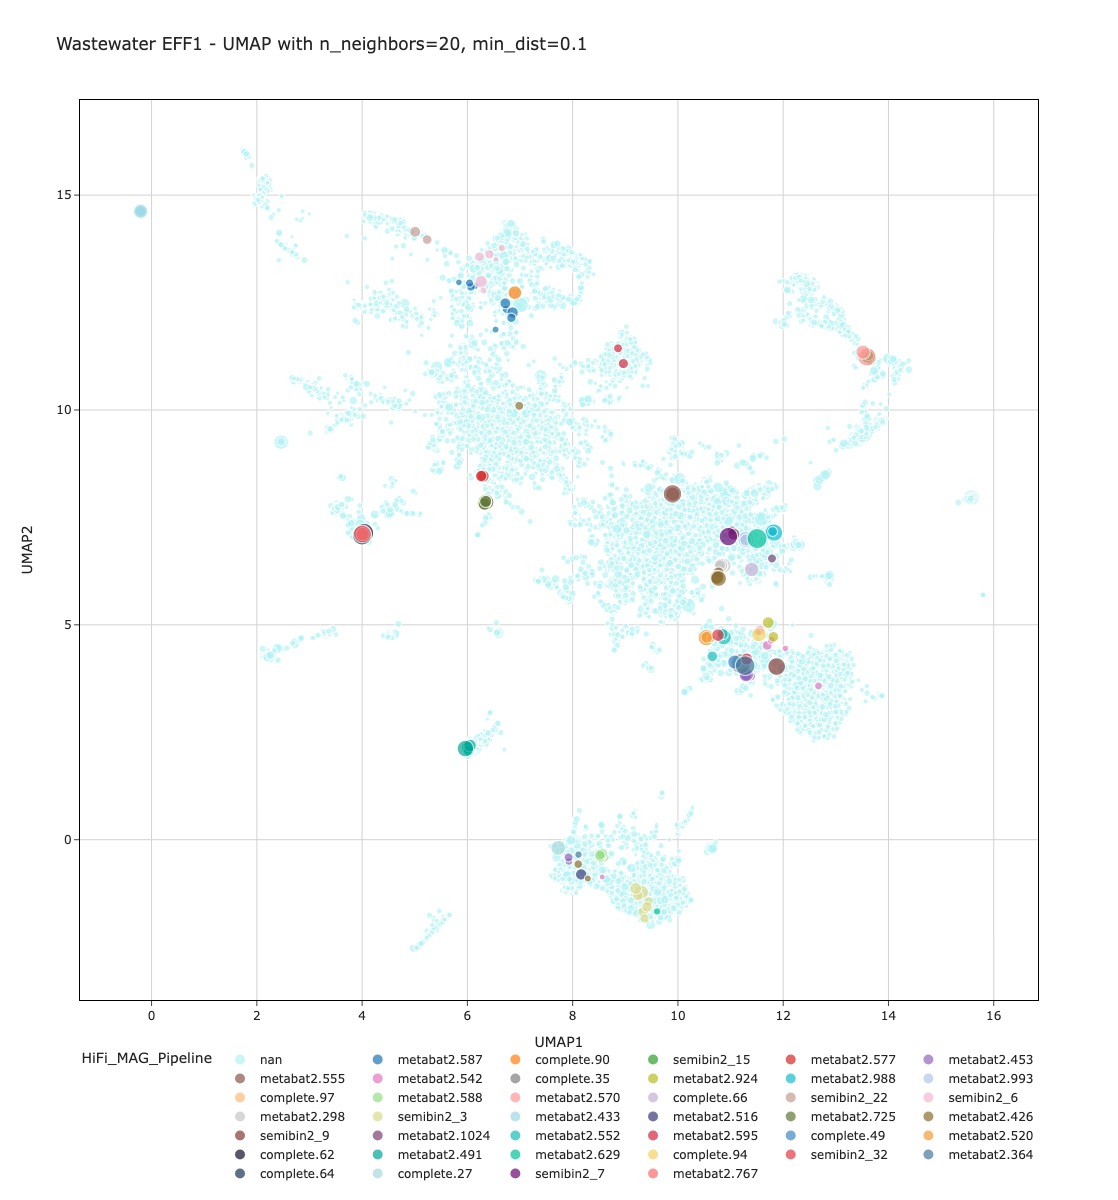

In [28]:
n_neighbors = [20]
min_dist = [0.1]

custom_colors = ["#b4f3f5", "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B", "#E377C2", "#7F7F7F",
"#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78", "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94",
"#F7B6D2", "#C7C7C7", "#DBDB8D", "#9EDAE5", "#393B79", "#637939", "#8C6D31", "#843C39",
"#7B4173", "#17BEBB", "#D7263D", "#3F88C5", "#F49D37", "#140F2D", "#00A896", "#02C39A",
"#F4D35E", "#E63946", "#457B9D", "#1D3557", "#A8DADC", "#6A0572", "#FF6B6B"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF1_df_focused_hifi_pipeline.iloc[:, :-9])
        EFF1_UMAP_df_focused_hifi_pipeline  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF1_df_focused_hifi_pipeline.index,
            'mod_count':EFF1_df_focused_hifi_pipeline['mod_count'],
            'mod_count_log':EFF1_df_focused_hifi_pipeline['mod_count_log'],
            'ARG_name':EFF1_df_focused_hifi_pipeline['ARG_name'],
            'ARG_count':EFF1_df_focused_hifi_pipeline['ARG_count'],
            'contig_length':EFF1_df_focused_hifi_pipeline['length'],
            'contig_length_sqrt':EFF1_df_focused_hifi_pipeline['length_sqrt'],
            'fARGene_class':EFF1_df_focused_hifi_pipeline['fARGene'],
            'HiFi_MAG_Pipeline':EFF1_df_focused_hifi_pipeline['HiFi_MAG_Pipeline']
        })

EFF1_UMAP_df_focused_hifi_pipeline['HiFi_MAG_Pipeline'] = EFF1_UMAP_df_focused_hifi_pipeline['HiFi_MAG_Pipeline'].astype(str)

        
fig = px.scatter(EFF1_UMAP_df_focused_hifi_pipeline, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='HiFi_MAG_Pipeline',
                 title=f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1200, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_analysis_WW_above50/EFF1_UMAP_{n}_{m}_focused_hifi_mags.png')
fig.write_html(f'UMAP_analysis_WW_above50/EFF1_UMAP_{n}_{m}_focused_hifi_mags.html')

# EFF2 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_matrices_top50/flattened/EFF2_concat_matrices_top50.tsv'
EFF2_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(EFF2_matrices.shape[0])

In [ ]:
print(EFF2_matrices.shape)
EFF2_matrices.head()

In [ ]:
EFF2_df = EFF2_matrices.loc[(EFF2_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
EFF2_df['sample'].value_counts()
print(EFF2_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_contigs/EFF2_mod_counts.txt'

EFF2_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF2_df_mod_counts.shape[0])
EFF2_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
EFF2_df_ext = EFF2_df.copy()
EFF2_df_ext.head()
EFF2_df_mod_counts.head()

# Reorder to match
EFF2_df_ordered = EFF2_df_mod_counts.loc[EFF2_df_ext.index]

# Check the min mod counts
EFF2_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#EFF2_df_ordered['mod_count_log'] = np.log2(EFF2_df_ordered['mod_count'])
EFF2_df_ordered['mod_count_log'] = np.log(EFF2_df_ordered['mod_count'])

EFF2_df_mod_counts = pd.concat([EFF2_df_ext, EFF2_df_ordered], axis=1)
print(EFF2_df_mod_counts.iloc[:, :-3])
EFF2_df_mod_counts.head()
EFF2_df = EFF2_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_contigs/EFF2_ARG_counts.txt'

EFF2_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF2_df_ARG_counts.shape[0])
EFF2_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
EFF2_df_ext = EFF2_df.copy()
EFF2_df_ext.head()
EFF2_df_ARG_counts.head()

# Reorder to match
EFF2_df_ordered = EFF2_df_ARG_counts.loc[EFF2_df_ext.index]

EFF2_df_ARG_counts = pd.concat([EFF2_df_ext, EFF2_df_ordered], axis=1)
print(EFF2_df_ARG_counts.iloc[:, :-4])
EFF2_df_ARG_counts.head()
EFF2_df = EFF2_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_contigs/EFF2_ARG_names.txt'

EFF2_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF2_df_ARG_names.shape[0])
EFF2_df_ARG_names.head()

# Replace NaN with empty
EFF2_df_ARG_names = EFF2_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
EFF2_df_ext = EFF2_df.copy()
EFF2_df_ext.head()
EFF2_df_ARG_names.head()

# Reorder to match
EFF2_df_ordered = EFF2_df_ARG_names.loc[EFF2_df_ext.index]

EFF2_df_ARG_names = pd.concat([EFF2_df_ext, EFF2_df_ordered], axis=1)
print(EFF2_df_ARG_names.iloc[:, :-5])
EFF2_df_ARG_names.head()
EFF2_df = EFF2_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_contigs/EFF2_contigs_lengths.txt'

EFF2_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF2_df_contigs_lengths.shape[0])
EFF2_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
EFF2_df_ext = EFF2_df.copy()
EFF2_df_ext.head()
EFF2_df_contigs_lengths.head()

# Reorder to match
EFF2_df_ordered = EFF2_df_contigs_lengths.loc[EFF2_df_ext.index]

# Log transform
EFF2_df_ordered['length_sqrt'] = np.sqrt(EFF2_df_ordered['length'])

# Concat
EFF2_df_contigs_lengths = pd.concat([EFF2_df_ext, EFF2_df_ordered], axis=1)
print(EFF2_df_contigs_lengths.iloc[:, :-7])
EFF2_df_contigs_lengths.head()
EFF2_df = EFF2_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF2_contigs/EFF2_fARGene_names.txt'

EFF2_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF2_df_fARGene_names.shape[0])
EFF2_df_fARGene_names.head()

# Replace NaN with empty
EFF2_df_fARGene_names = EFF2_df_fARGene_names.fillna('')
EFF2_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
EFF2_df_ext = EFF2_df.copy()
EFF2_df_ext.head()
EFF2_df_fARGene_names.head()

# Reorder to match
EFF2_df_ordered = EFF2_df_fARGene_names.loc[EFF2_df_ext.index]

EFF2_df_fARGene_names = pd.concat([EFF2_df_ext, EFF2_df_ordered], axis=1)
print(EFF2_df_fARGene_names.iloc[:, :-8])
EFF2_df_fARGene_names.head()
EFF2_df = EFF2_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = EFF2_df[EFF2_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
EFF2_df.head()
#print(EFF1_df.iloc[:, :-8])
#print(EFF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF2_df.iloc[:, :-8])
        EFF2_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF2_df.index,
            'mod_count':EFF2_df['mod_count'],
            'mod_count_log':EFF2_df['mod_count_log'],
            'ARG_name':EFF2_df['ARG_name'],
            'ARG_count':EFF2_df['ARG_count'],
            'contig_length':EFF2_df['length'],
            'contig_length_sqrt':EFF2_df['length_sqrt'],
            'fARGene_class':EFF2_df['fARGene']
        })

        #EFF2_UMAP_df['ARG_count'] = EFF2_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(EFF2_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/EFF2_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/EFF2_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_UMAP_df_focused = EFF2_UMAP_df.loc[(EFF2_UMAP_df['UMAP1']>= 3) & (EFF2_UMAP_df['UMAP1']<= 15)
    & (EFF2_UMAP_df['UMAP2']>= -2) & (EFF2_UMAP_df['UMAP2']<= 16)]

# Check
EFF2_UMAP_df_focused.head()

EFF2_df_focused = EFF2_df[EFF2_df.index.isin(EFF2_UMAP_df_focused['contig'])]
print(EFF2_df_focused)

In [ ]:
# Save contig IDs
EFF2_focused_contigs = EFF2_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(EFF2_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF2_df_focused.iloc[:, :-8])
        EFF2_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF2_df_focused.index,
            'mod_count':EFF2_df_focused['mod_count'],
            'mod_count_log':EFF2_df_focused['mod_count_log'],
            'ARG_name':EFF2_df_focused['ARG_name'],
            'ARG_count':EFF2_df_focused['ARG_count'],
            'contig_length':EFF2_df_focused['length'],
            'contig_length_sqrt':EFF2_df_focused['length_sqrt'],
            'fARGene_class':EFF2_df_focused['fARGene']
        })

        EFF2_UMAP_df_focused['ARG_count'] = EFF2_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(EFF2_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#EFF2_df_focused.head()
#EFF2_UMAP_df_focused.head()

In [ ]:
# Save data
EFF2_df_focused.to_csv('UMAP_WW_above50/EFF2_df_focused.csv', sep='\t', index=True)
EFF2_UMAP_df_focused.to_csv('UMAP_WW_above50/EFF2_UMAP_df_focused.csv', sep='\t', index=True)

# EFF2: Read in and plot

In [ ]:
# Read data
EFF2_df_focused = pd.read_csv('UMAP_WW_above50/EFF2_df_focused.csv', sep='\t', index_col=0, low_memory=False)
EFF2_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/EFF2_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
EFF2_df_focused.head()
EFF2_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

EFF2_UMAP_df_focused['ARG_count'] = EFF2_UMAP_df_focused['ARG_count'].astype(str)

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF2_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(EFF2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
#fig.write_image(f'UMAP_WW_above50/EFF2_UMAP_{n}_{m}_focused_ARG_counts.png')
#fig.write_html(f'UMAP_WW_above50/EFF2_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C1 = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 9) & (EFF2_UMAP_df_focused['UMAP1']<= 9.1)
    & (EFF2_UMAP_df_focused['UMAP2']>= 7.65) & (EFF2_UMAP_df_focused['UMAP2']<= 7.7)]

# Check
EFF2_df_focused_C1.head()

EFF2_df_C1 = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C1['contig'])]
print(EFF2_df_C1)

In [ ]:
# Save contig IDs
EFF2_C1_contigs = EFF2_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C2 = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 8.15) & (EFF2_UMAP_df_focused['UMAP1']<= 8.2)
    & (EFF2_UMAP_df_focused['UMAP2']>= 8.61) & (EFF2_UMAP_df_focused['UMAP2']<= 8.62)]

# Check
EFF2_df_focused_C2.head()

EFF2_df_C2 = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C2['contig'])]
print(EFF2_df_C2)

In [ ]:
# Save contig IDs
EFF2_C2_contigs = EFF2_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C3 = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 7.5) & (EFF2_UMAP_df_focused['UMAP1']<= 8)
    & (EFF2_UMAP_df_focused['UMAP2']>= -0.6) & (EFF2_UMAP_df_focused['UMAP2']<= -0.4)]

# Check
EFF2_df_focused_C3.head()

EFF2_df_C3 = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C3['contig'])]
print(EFF2_df_C3)

In [ ]:
# Save contig IDs
EFF2_C3_contigs = EFF2_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C4 = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 3) & (EFF2_UMAP_df_focused['UMAP1']<= 3.2)
    & (EFF2_UMAP_df_focused['UMAP2']>= 11.2) & (EFF2_UMAP_df_focused['UMAP2']<= 11.3)]

# Check
EFF2_df_focused_C4.head()

EFF2_df_C4 = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C4['contig'])]
print(EFF2_df_C4)

In [ ]:
# Save contig IDs
EFF2_C4_contigs = EFF2_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C4_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#b4f3f5', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

EFF2_UMAP_df_focused['fARGene_class'] = EFF2_UMAP_df_focused['fARGene_class'].astype(str)
EFF2_UMAP_df_focused['fARGene_class'] = EFF2_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF2_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(EFF2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/EFF2_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/EFF2_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(EFF2_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C1f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 9.8) & (EFF2_UMAP_df_focused['UMAP1']<= 10)
    & (EFF2_UMAP_df_focused['UMAP2']>= 4.3) & (EFF2_UMAP_df_focused['UMAP2']<= 4.5)]

# Check
EFF2_df_focused_C1f.head()

EFF2_df_C1f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C1f['contig'])]
print(EFF2_df_C1f)

In [ ]:
# Save contig IDs
EFF2_C1f_contigs = EFF2_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C2f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 11.6) & (EFF2_UMAP_df_focused['UMAP1']<= 11.8)
    & (EFF2_UMAP_df_focused['UMAP2']>= 5.6) & (EFF2_UMAP_df_focused['UMAP2']<= 5.7)]

# Check
EFF2_df_focused_C2f.head()

EFF2_df_C2f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C2f['contig'])]
print(EFF2_df_C2f)

In [ ]:
# Save contig IDs
EFF2_C2f_contigs = EFF2_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C3f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 9.55) & (EFF2_UMAP_df_focused['UMAP1']<= 9.65)
    & (EFF2_UMAP_df_focused['UMAP2']>= 7.85) & (EFF2_UMAP_df_focused['UMAP2']<= 7.95)]

# Check
EFF2_df_focused_C3f.head()

EFF2_df_C3f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C3f['contig'])]
print(EFF2_df_C3f)

In [ ]:
# Save contig IDs
EFF2_C3f_contigs = EFF2_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C4f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 9.54) & (EFF2_UMAP_df_focused['UMAP1']<= 9.6)
    & (EFF2_UMAP_df_focused['UMAP2']>= 7.405) & (EFF2_UMAP_df_focused['UMAP2']<= 7.45)]

# Check
EFF2_df_focused_C4f.head()

EFF2_df_C4f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C4f['contig'])]
print(EFF2_df_C4f)

In [ ]:
# Save contig IDs
EFF2_C4f_contigs = EFF2_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C5f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 7.2) & (EFF2_UMAP_df_focused['UMAP1']<= 7.4)
    & (EFF2_UMAP_df_focused['UMAP2']>= 9.08) & (EFF2_UMAP_df_focused['UMAP2']<= 9.12)]

# Check
EFF2_df_focused_C5f.head()

EFF2_df_C5f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C5f['contig'])]
print(EFF2_df_C5f)

In [ ]:
# Save contig IDs
EFF2_C5f_contigs = EFF2_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF2_df_focused_C6f = EFF2_UMAP_df_focused.loc[(EFF2_UMAP_df_focused['UMAP1']>= 7.8) & (EFF2_UMAP_df_focused['UMAP1']<= 8)
    & (EFF2_UMAP_df_focused['UMAP2']>= 9.5) & (EFF2_UMAP_df_focused['UMAP2']<= 9.55)]

# Check
EFF2_df_focused_C6f.head()

EFF2_df_C6f = EFF2_df_focused[EFF2_df_focused.index.isin(EFF2_df_focused_C6f['contig'])]
print(EFF2_df_C6f)

In [ ]:
# Save contig IDs
EFF2_C6f_contigs = EFF2_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF2_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF2_C6f_contigs:
        file.write(f"{item}\n")

# EFF3 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_matrices_top50/flattened/EFF3_concat_matrices_top50.tsv'
EFF3_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(EFF3_matrices.shape[0])

In [ ]:
print(EFF3_matrices.shape)
EFF3_matrices.head()

In [ ]:
EFF3_df = EFF3_matrices.loc[(EFF3_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
EFF3_df['sample'].value_counts()
print(EFF3_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_contigs/EFF3_mod_counts.txt'

EFF3_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF3_df_mod_counts.shape[0])
EFF3_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
EFF3_df_ext = EFF3_df.copy()
EFF3_df_ext.head()
EFF3_df_mod_counts.head()

# Reorder to match
EFF3_df_ordered = EFF3_df_mod_counts.loc[EFF3_df_ext.index]

# Check the min mod counts
EFF3_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#EFF3_df_ordered['mod_count_log'] = np.log2(EFF3_df_ordered['mod_count'])
EFF3_df_ordered['mod_count_log'] = np.log(EFF3_df_ordered['mod_count'])

EFF3_df_mod_counts = pd.concat([EFF3_df_ext, EFF3_df_ordered], axis=1)
print(EFF3_df_mod_counts.iloc[:, :-3])
EFF3_df_mod_counts.head()
EFF3_df = EFF3_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_contigs/EFF3_ARG_counts.txt'

EFF3_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF3_df_ARG_counts.shape[0])
EFF3_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
EFF3_df_ext = EFF3_df.copy()
EFF3_df_ext.head()
EFF3_df_ARG_counts.head()

# Reorder to match
EFF3_df_ordered = EFF3_df_ARG_counts.loc[EFF3_df_ext.index]

EFF3_df_ARG_counts = pd.concat([EFF3_df_ext, EFF3_df_ordered], axis=1)
print(EFF3_df_ARG_counts.iloc[:, :-4])
EFF3_df_ARG_counts.head()
EFF3_df = EFF3_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_contigs/EFF3_ARG_names.txt'

EFF3_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF3_df_ARG_names.shape[0])
EFF3_df_ARG_names.head()

# Replace NaN with empty
EFF3_df_ARG_names = EFF3_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
EFF3_df_ext = EFF3_df.copy()
EFF3_df_ext.head()
EFF3_df_ARG_names.head()

# Reorder to match
EFF3_df_ordered = EFF3_df_ARG_names.loc[EFF3_df_ext.index]

EFF3_df_ARG_names = pd.concat([EFF3_df_ext, EFF3_df_ordered], axis=1)
print(EFF3_df_ARG_names.iloc[:, :-5])
EFF3_df_ARG_names.head()
EFF3_df = EFF3_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_contigs/EFF3_contigs_lengths.txt'

EFF3_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF3_df_contigs_lengths.shape[0])
EFF3_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
EFF3_df_ext = EFF3_df.copy()
EFF3_df_ext.head()
EFF3_df_contigs_lengths.head()

# Reorder to match
EFF3_df_ordered = EFF3_df_contigs_lengths.loc[EFF3_df_ext.index]

# Log transform
EFF3_df_ordered['length_sqrt'] = np.sqrt(EFF3_df_ordered['length'])

# Concat
EFF3_df_contigs_lengths = pd.concat([EFF3_df_ext, EFF3_df_ordered], axis=1)
print(EFF3_df_contigs_lengths.iloc[:, :-7])
EFF3_df_contigs_lengths.head()
EFF3_df = EFF3_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/EFF3_contigs/EFF3_fARGene_names.txt'

EFF3_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(EFF3_df_fARGene_names.shape[0])
EFF3_df_fARGene_names.head()

# Replace NaN with empty
EFF3_df_fARGene_names = EFF3_df_fARGene_names.fillna('')
EFF3_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
EFF3_df_ext = EFF3_df.copy()
EFF3_df_ext.head()
EFF3_df_fARGene_names.head()

# Reorder to match
EFF3_df_ordered = EFF3_df_fARGene_names.loc[EFF3_df_ext.index]

EFF3_df_fARGene_names = pd.concat([EFF3_df_ext, EFF3_df_ordered], axis=1)
print(EFF3_df_fARGene_names.iloc[:, :-8])
EFF3_df_fARGene_names.head()
EFF3_df = EFF3_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = EFF3_df[EFF3_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
EFF3_df.head()
#print(EFF1_df.iloc[:, :-8])
#print(EFF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF3_df.iloc[:, :-8])
        EFF3_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF3_df.index,
            'mod_count':EFF3_df['mod_count'],
            'mod_count_log':EFF3_df['mod_count_log'],
            'ARG_name':EFF3_df['ARG_name'],
            'ARG_count':EFF3_df['ARG_count'],
            'contig_length':EFF3_df['length'],
            'contig_length_sqrt':EFF3_df['length_sqrt'],
            'fARGene_class':EFF3_df['fARGene']
        })

        #EFF3_UMAP_df['ARG_count'] = EFF3_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(EFF3_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/EFF3_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/EFF3_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_UMAP_df_focused = EFF3_UMAP_df.loc[(EFF3_UMAP_df['UMAP1']>= 0) & (EFF3_UMAP_df['UMAP1']<= 12)
    & (EFF3_UMAP_df['UMAP2']>= -1) & (EFF3_UMAP_df['UMAP2']<= 16)]

# Check
EFF3_UMAP_df_focused.head()

EFF3_df_focused = EFF3_df[EFF3_df.index.isin(EFF3_UMAP_df_focused['contig'])]
print(EFF3_df_focused)

In [ ]:
# Save contig IDs
EFF3_focused_contigs = EFF3_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(EFF3_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF3_df_focused.iloc[:, :-8])
        EFF3_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': EFF3_df_focused.index,
            'mod_count':EFF3_df_focused['mod_count'],
            'mod_count_log':EFF3_df_focused['mod_count_log'],
            'ARG_name':EFF3_df_focused['ARG_name'],
            'ARG_count':EFF3_df_focused['ARG_count'],
            'contig_length':EFF3_df_focused['length'],
            'contig_length_sqrt':EFF3_df_focused['length_sqrt'],
            'fARGene_class':EFF3_df_focused['fARGene']
        })

        EFF3_UMAP_df_focused['ARG_count'] = EFF3_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(EFF3_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#EFF3_df_focused.head()
#EFF3_UMAP_df_focused.head()

In [ ]:
# Save data
EFF3_df_focused.to_csv('UMAP_WW_above50/EFF3_df_focused.csv', sep='\t', index=True)
EFF3_UMAP_df_focused.to_csv('UMAP_WW_above50/EFF3_UMAP_df_focused.csv', sep='\t', index=True)

# EFF3: Read in and plot

In [ ]:
# Read data
EFF3_df_focused = pd.read_csv('UMAP_WW_above50/EFF3_df_focused.csv', sep='\t', index_col=0, low_memory=False)
EFF3_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/EFF3_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
EFF3_df_focused.head()
EFF3_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#b4f3f5', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}
category_order = ["0", "1", "2", "3"]

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

EFF3_UMAP_df_focused['ARG_count'] = EFF3_UMAP_df_focused['ARG_count'].astype(str)

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF3_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(EFF3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_sequence=custom_colors,
                 category_orders={'ARG_count': category_order},
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/EFF3_UMAP_{n}_{m}_focused_ARG_counts.png')
fig.write_html(f'UMAP_WW_above50/EFF3_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_df_focused_C1 = EFF3_UMAP_df_focused.loc[(EFF3_UMAP_df_focused['UMAP1']>= 7.1) & (EFF3_UMAP_df_focused['UMAP1']<= 7.3)
    & (EFF3_UMAP_df_focused['UMAP2']>= 6.6) & (EFF3_UMAP_df_focused['UMAP2']<= 6.7)]

# Check
EFF3_df_focused_C1.head()

EFF3_df_C1 = EFF3_df_focused[EFF3_df_focused.index.isin(EFF3_df_focused_C1['contig'])]
print(EFF3_df_C1)

In [ ]:
# Save contig IDs
EFF3_C1_contigs = EFF3_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_C1_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#b4f3f5', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

EFF3_UMAP_df_focused['fARGene_class'] = EFF3_UMAP_df_focused['fARGene_class'].astype(str)
EFF3_UMAP_df_focused['fARGene_class'] = EFF3_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(EFF3_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(EFF3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater EFF3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/EFF3_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/EFF3_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(EFF3_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_df_focused_C1f = EFF3_UMAP_df_focused.loc[(EFF3_UMAP_df_focused['UMAP1']>= 4) & (EFF3_UMAP_df_focused['UMAP1']<= 4.3)
    & (EFF3_UMAP_df_focused['UMAP2']>= 10.1) & (EFF3_UMAP_df_focused['UMAP2']<= 10.3)]

# Check
EFF3_df_focused_C1f.head()

EFF3_df_C1f = EFF3_df_focused[EFF3_df_focused.index.isin(EFF3_df_focused_C1f['contig'])]
print(EFF3_df_C1f)

In [ ]:
# Save contig IDs
EFF3_C1f_contigs = EFF3_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_df_focused_C2f = EFF3_UMAP_df_focused.loc[(EFF3_UMAP_df_focused['UMAP1']>= 4) & (EFF3_UMAP_df_focused['UMAP1']<= 4.1)
    & (EFF3_UMAP_df_focused['UMAP2']>= 9.72) & (EFF3_UMAP_df_focused['UMAP2']<= 9.73)]

# Check
EFF3_df_focused_C2f.head()

EFF3_df_C2f = EFF3_df_focused[EFF3_df_focused.index.isin(EFF3_df_focused_C2f['contig'])]
print(EFF3_df_C2f)

In [ ]:
# Save contig IDs
EFF3_C2f_contigs = EFF3_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_df_focused_C3f = EFF3_UMAP_df_focused.loc[(EFF3_UMAP_df_focused['UMAP1']>= 0.68) & (EFF3_UMAP_df_focused['UMAP1']<= 0.8)
    & (EFF3_UMAP_df_focused['UMAP2']>= 6.63) & (EFF3_UMAP_df_focused['UMAP2']<= 6.65)]

# Check
EFF3_df_focused_C3f.head()

EFF3_df_C3f = EFF3_df_focused[EFF3_df_focused.index.isin(EFF3_df_focused_C3f['contig'])]
print(EFF3_df_C3f)

In [ ]:
# Save contig IDs
EFF3_C3f_contigs = EFF3_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
EFF3_df_focused_C4f = EFF3_UMAP_df_focused.loc[(EFF3_UMAP_df_focused['UMAP1']>= 4.4) & (EFF3_UMAP_df_focused['UMAP1']<= 4.45)
    & (EFF3_UMAP_df_focused['UMAP2']>= 9.55) & (EFF3_UMAP_df_focused['UMAP2']<= 9.57)]

# Check
EFF3_df_focused_C4f.head()

EFF3_df_C4f = EFF3_df_focused[EFF3_df_focused.index.isin(EFF3_df_focused_C4f['contig'])]
print(EFF3_df_C4f)

In [ ]:
# Save contig IDs
EFF3_C4f_contigs = EFF3_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'EFF3_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in EFF3_C4f_contigs:
        file.write(f"{item}\n")

# INF1 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_matrices_top50/flattened/INF1_concat_matrices_top50.tsv'
INF1_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(INF1_matrices.shape[0])

In [ ]:
print(INF1_matrices.shape)
INF1_matrices.head()

In [ ]:
INF1_df = INF1_matrices.loc[(INF1_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
INF1_df['sample'].value_counts()
print(INF1_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_contigs/INF1_mod_counts.txt'

INF1_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF1_df_mod_counts.shape[0])
INF1_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
INF1_df_ext = INF1_df.copy()
INF1_df_ext.head()
INF1_df_mod_counts.head()

# Reorder to match
INF1_df_ordered = INF1_df_mod_counts.loc[INF1_df_ext.index]

# Check the min mod counts
INF1_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#INF1_df_ordered['mod_count_log'] = np.log2(INF1_df_ordered['mod_count'])
INF1_df_ordered['mod_count_log'] = np.log(INF1_df_ordered['mod_count'])

INF1_df_mod_counts = pd.concat([INF1_df_ext, INF1_df_ordered], axis=1)
print(INF1_df_mod_counts.iloc[:, :-3])
INF1_df_mod_counts.head()
INF1_df = INF1_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_contigs/INF1_ARG_counts.txt'

INF1_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF1_df_ARG_counts.shape[0])
INF1_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
INF1_df_ext = INF1_df.copy()
INF1_df_ext.head()
INF1_df_ARG_counts.head()

# Reorder to match
INF1_df_ordered = INF1_df_ARG_counts.loc[INF1_df_ext.index]

INF1_df_ARG_counts = pd.concat([INF1_df_ext, INF1_df_ordered], axis=1)
print(INF1_df_ARG_counts.iloc[:, :-4])
INF1_df_ARG_counts.head()
INF1_df = INF1_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_contigs/INF1_ARG_names.txt'

INF1_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF1_df_ARG_names.shape[0])
INF1_df_ARG_names.head()

# Replace NaN with empty
INF1_df_ARG_names = INF1_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
INF1_df_ext = INF1_df.copy()
INF1_df_ext.head()
INF1_df_ARG_names.head()

# Reorder to match
INF1_df_ordered = INF1_df_ARG_names.loc[INF1_df_ext.index]

INF1_df_ARG_names = pd.concat([INF1_df_ext, INF1_df_ordered], axis=1)
print(INF1_df_ARG_names.iloc[:, :-5])
INF1_df_ARG_names.head()
INF1_df = INF1_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_contigs/INF1_contigs_lengths.txt'

INF1_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF1_df_contigs_lengths.shape[0])
INF1_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
INF1_df_ext = INF1_df.copy()
INF1_df_ext.head()
INF1_df_contigs_lengths.head()

# Reorder to match
INF1_df_ordered = INF1_df_contigs_lengths.loc[INF1_df_ext.index]

# Log transform
INF1_df_ordered['length_sqrt'] = np.sqrt(INF1_df_ordered['length'])

# Concat
INF1_df_contigs_lengths = pd.concat([INF1_df_ext, INF1_df_ordered], axis=1)
print(INF1_df_contigs_lengths.iloc[:, :-7])
INF1_df_contigs_lengths.head()
INF1_df = INF1_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF1_contigs/INF1_fARGene_names.txt'

INF1_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF1_df_fARGene_names.shape[0])
INF1_df_fARGene_names.head()

# Replace NaN with empty
INF1_df_fARGene_names = INF1_df_fARGene_names.fillna('')
INF1_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
INF1_df_ext = INF1_df.copy()
INF1_df_ext.head()
INF1_df_fARGene_names.head()

# Reorder to match
INF1_df_ordered = INF1_df_fARGene_names.loc[INF1_df_ext.index]

INF1_df_fARGene_names = pd.concat([INF1_df_ext, INF1_df_ordered], axis=1)
print(INF1_df_fARGene_names.iloc[:, :-8])
INF1_df_fARGene_names.head()
INF1_df = INF1_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = INF1_df[INF1_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
INF1_df.head()
#print(INF1_df.iloc[:, :-8])
#print(INF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF1_df.iloc[:, :-8])
        INF1_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF1_df.index,
            'mod_count':INF1_df['mod_count'],
            'mod_count_log':INF1_df['mod_count_log'],
            'ARG_name':INF1_df['ARG_name'],
            'ARG_count':INF1_df['ARG_count'],
            'contig_length':INF1_df['length'],
            'contig_length_sqrt':INF1_df['length_sqrt'],
            'fARGene_class':INF1_df['fARGene']
        })

        #INF1_UMAP_df['ARG_count'] = INF1_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(INF1_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/INF1_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/INF1_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_UMAP_df_focused = INF1_UMAP_df.loc[(INF1_UMAP_df['UMAP1']>= 1) & (INF1_UMAP_df['UMAP1']<= 15)
    & (INF1_UMAP_df['UMAP2']>= -4) & (INF1_UMAP_df['UMAP2']<= 15)]

# Check
INF1_UMAP_df_focused.head()

INF1_df_focused = INF1_df[INF1_df.index.isin(INF1_UMAP_df_focused['contig'])]
print(INF1_df_focused)

In [ ]:
# Save contig IDs
INF1_focused_contigs = INF1_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(INF1_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF1_df_focused.iloc[:, :-8])
        INF1_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF1_df_focused.index,
            'mod_count':INF1_df_focused['mod_count'],
            'mod_count_log':INF1_df_focused['mod_count_log'],
            'ARG_name':INF1_df_focused['ARG_name'],
            'ARG_count':INF1_df_focused['ARG_count'],
            'contig_length':INF1_df_focused['length'],
            'contig_length_sqrt':INF1_df_focused['length_sqrt'],
            'fARGene_class':INF1_df_focused['fARGene']
        })

        INF1_UMAP_df_focused['ARG_count'] = INF1_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(INF1_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
INF1_df_focused.head()
INF1_UMAP_df_focused.head()

In [ ]:
# Save data
INF1_df_focused.to_csv('UMAP_WW_above50/INF1_df_focused.csv', sep='\t', index=True)
INF1_UMAP_df_focused.to_csv('UMAP_WW_above50/INF1_UMAP_df_focused.csv', sep='\t', index=True)

# INF1: Read in and plot

In [ ]:
# Read data
INF1_df_focused = pd.read_csv('UMAP_WW_above50/INF1_df_focused.csv', sep='\t', index_col=0, low_memory=False)
INF1_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/INF1_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
INF1_df_focused.head()
INF1_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

INF1_UMAP_df_focused['ARG_count'] = INF1_UMAP_df_focused['ARG_count'].astype(str)
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF1_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(INF1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
#fig.write_image(f'UMAP_WW_above50/INF1_UMAP_{n}_{m}_focused_ARG_counts.png')
#fig.write_html(f'UMAP_WW_above50/INF1_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C1 = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= 5) & (INF1_UMAP_df_focused['UMAP1']<= 10)
    & (INF1_UMAP_df_focused['UMAP2']>= 5) & (INF1_UMAP_df_focused['UMAP2']<= 6.7)]

# Check
INF1_df_focused_C1.head()

INF1_df_C1 = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C1['contig'])]
print(INF1_df_C1)

In [ ]:
# Save contig IDs
INF1_C1_contigs = INF1_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C2 = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= 6.9) & (INF1_UMAP_df_focused['UMAP1']<= 7.2)
    & (INF1_UMAP_df_focused['UMAP2']>= 14.5) & (INF1_UMAP_df_focused['UMAP2']<= 14.6)]

# Check
INF1_df_focused_C2.head()

INF1_df_C2 = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C2['contig'])]
print(INF1_df_C2)

In [ ]:
# Save contig IDs
INF1_C2_contigs = INF1_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C3 = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= 2.6) & (INF1_UMAP_df_focused['UMAP1']<= 2.8)
    & (INF1_UMAP_df_focused['UMAP2']>= 2.1) & (INF1_UMAP_df_focused['UMAP2']<= 2.2)]

# Check
INF1_df_focused_C3.head()

INF1_df_C3 = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C3['contig'])]
print(INF1_df_C3)

In [ ]:
# Save contig IDs
INF1_C3_contigs = INF1_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C4 = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -1.69) & (INF1_UMAP_df_focused['UMAP1']<= -1.635)
    & (INF1_UMAP_df_focused['UMAP2']>= -0.99) & (INF1_UMAP_df_focused['UMAP2']<= -0.93)]

# Check
INF1_df_focused_C4.head()

INF1_df_C4 = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C4['contig'])]
print(INF1_df_C4)

In [ ]:
# Save contig IDs
INF1_C4_contigs = INF1_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C4_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#dcd377', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

INF1_UMAP_df_focused['fARGene_class'] = INF1_UMAP_df_focused['fARGene_class'].astype(str)
INF1_UMAP_df_focused['fARGene_class'] = INF1_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF1_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(INF1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/INF1_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/INF1_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(INF1_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C1f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= 3.65) & (INF1_UMAP_df_focused['UMAP1']<= 3.75)
    & (INF1_UMAP_df_focused['UMAP2']>= 4.53) & (INF1_UMAP_df_focused['UMAP2']<= 4.62)]

# Check
INF1_df_focused_C1f.head()

INF1_df_C1f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C1f['contig'])]
print(INF1_df_C1f)

In [ ]:
# Save contig IDs
INF1_C1f_contigs = INF1_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C2f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -2.045) & (INF1_UMAP_df_focused['UMAP1']<= -1.9)
    & (INF1_UMAP_df_focused['UMAP2']>= 7.51) & (INF1_UMAP_df_focused['UMAP2']<= 7.6)]

# Check
INF1_df_focused_C2f.head()

INF1_df_C2f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C2f['contig'])]
print(INF1_df_C2f)

In [ ]:
# Save contig IDs
INF1_C2f_contigs = INF1_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C3f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -2.35) & (INF1_UMAP_df_focused['UMAP1']<= -2.2)
    & (INF1_UMAP_df_focused['UMAP2']>= 7.65) & (INF1_UMAP_df_focused['UMAP2']<= 7.76)]

# Check
INF1_df_focused_C3f.head()

INF1_df_C3f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C3f['contig'])]
print(INF1_df_C3f)

In [ ]:
# Save contig IDs
INF1_C3f_contigs = INF1_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C4f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -0.6) & (INF1_UMAP_df_focused['UMAP1']<= -0.56)
    & (INF1_UMAP_df_focused['UMAP2']>= 9.97) & (INF1_UMAP_df_focused['UMAP2']<= 9.98)]

# Check
INF1_df_focused_C4f.head()

INF1_df_C4f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C4f['contig'])]
print(INF1_df_C4f)

In [ ]:
# Save contig IDs
INF1_C4f_contigs = INF1_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C5f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -2.8) & (INF1_UMAP_df_focused['UMAP1']<= -2.73)
    & (INF1_UMAP_df_focused['UMAP2']>= 9.88) & (INF1_UMAP_df_focused['UMAP2']<= 9.92)]

# Check
INF1_df_focused_C5f.head()

INF1_df_C5f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C5f['contig'])]
print(INF1_df_C5f)

In [ ]:
# Save contig IDs
INF1_C5f_contigs = INF1_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF1_df_focused_C6f = INF1_UMAP_df_focused.loc[(INF1_UMAP_df_focused['UMAP1']>= -2.6) & (INF1_UMAP_df_focused['UMAP1']<= -2.4)
    & (INF1_UMAP_df_focused['UMAP2']>= 7.2) & (INF1_UMAP_df_focused['UMAP2']<= 7.4)]

# Check
INF1_df_focused_C6f.head()

INF1_df_C6f = INF1_df_focused[INF1_df_focused.index.isin(INF1_df_focused_C6f['contig'])]
print(INF1_df_C6f)

In [ ]:
# Save contig IDs
INF1_C6f_contigs = INF1_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF1_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF1_C6f_contigs:
        file.write(f"{item}\n")

# INF2 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
#Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_matrices_top50/flattened/INF2_concat_matrices_top50.tsv'
INF2_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(INF2_matrices.shape[0])

In [ ]:
print(INF2_matrices.shape)
INF2_matrices.head()

In [ ]:
INF2_df = INF2_matrices.loc[(INF2_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
INF2_df['sample'].value_counts()
print(INF2_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_contigs/INF2_mod_counts.txt'

INF2_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF2_df_mod_counts.shape[0])
INF2_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
INF2_df_ext = INF2_df.copy()
INF2_df_ext.head()
INF2_df_mod_counts.head()

# Reorder to match
INF2_df_ordered = INF2_df_mod_counts.loc[INF2_df_ext.index]

# Check the min mod counts
INF2_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#INF2_df_ordered['mod_count_log'] = np.log2(INF2_df_ordered['mod_count'])
INF2_df_ordered['mod_count_log'] = np.log(INF2_df_ordered['mod_count'])

INF2_df_mod_counts = pd.concat([INF2_df_ext, INF2_df_ordered], axis=1)
print(INF2_df_mod_counts.iloc[:, :-3])
INF2_df_mod_counts.head()
INF2_df = INF2_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_contigs/INF2_ARG_counts.txt'

INF2_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF2_df_ARG_counts.shape[0])
INF2_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
INF2_df_ext = INF2_df.copy()
INF2_df_ext.head()
INF2_df_ARG_counts.head()

# Reorder to match
INF2_df_ordered = INF2_df_ARG_counts.loc[INF2_df_ext.index]

INF2_df_ARG_counts = pd.concat([INF2_df_ext, INF2_df_ordered], axis=1)
print(INF2_df_ARG_counts.iloc[:, :-4])
INF2_df_ARG_counts.head()
INF2_df = INF2_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_contigs/INF2_ARG_names.txt'

INF2_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF2_df_ARG_names.shape[0])
INF2_df_ARG_names.head()

# Replace NaN with empty
INF2_df_ARG_names = INF2_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
INF2_df_ext = INF2_df.copy()
INF2_df_ext.head()
INF2_df_ARG_names.head()

# Reorder to match
INF2_df_ordered = INF2_df_ARG_names.loc[INF2_df_ext.index]

INF2_df_ARG_names = pd.concat([INF2_df_ext, INF2_df_ordered], axis=1)
print(INF2_df_ARG_names.iloc[:, :-5])
INF2_df_ARG_names.head()
INF2_df = INF2_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_contigs/INF2_contigs_lengths.txt'

INF2_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF2_df_contigs_lengths.shape[0])
INF2_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
INF2_df_ext = INF2_df.copy()
INF2_df_ext.head()
INF2_df_contigs_lengths.head()

# Reorder to match
INF2_df_ordered = INF2_df_contigs_lengths.loc[INF2_df_ext.index]

# Log transform
INF2_df_ordered['length_sqrt'] = np.sqrt(INF2_df_ordered['length'])

# Concat
INF2_df_contigs_lengths = pd.concat([INF2_df_ext, INF2_df_ordered], axis=1)
print(INF2_df_contigs_lengths.iloc[:, :-7])
INF2_df_contigs_lengths.head()
INF2_df = INF2_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF2_contigs/INF2_fARGene_names.txt'

INF2_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF2_df_fARGene_names.shape[0])
INF2_df_fARGene_names.head()

# Replace NaN with empty
INF2_df_fARGene_names = INF2_df_fARGene_names.fillna('')
INF2_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
INF2_df_ext = INF2_df.copy()
INF2_df_ext.head()
INF2_df_fARGene_names.head()

# Reorder to match
INF2_df_ordered = INF2_df_fARGene_names.loc[INF2_df_ext.index]

INF2_df_fARGene_names = pd.concat([INF2_df_ext, INF2_df_ordered], axis=1)
print(INF2_df_fARGene_names.iloc[:, :-8])
INF2_df_fARGene_names.head()
INF2_df = INF2_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = INF2_df[INF2_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
INF2_df.head()
#print(INF1_df.iloc[:, :-8])
#print(INF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF2_df.iloc[:, :-8])
        INF2_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF2_df.index,
            'mod_count':INF2_df['mod_count'],
            'mod_count_log':INF2_df['mod_count_log'],
            'ARG_name':INF2_df['ARG_name'],
            'ARG_count':INF2_df['ARG_count'],
            'contig_length':INF2_df['length'],
            'contig_length_sqrt':INF2_df['length_sqrt'],
            'fARGene_class':INF2_df['fARGene']
        })

        #INF2_UMAP_df['ARG_count'] = INF2_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(INF2_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/INF2_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/INF2_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_UMAP_df_focused = INF2_UMAP_df.loc[(INF2_UMAP_df['UMAP1']>= 2.5) & (INF2_UMAP_df['UMAP1']<= 17)
    & (INF2_UMAP_df['UMAP2']>= -6) & (INF2_UMAP_df['UMAP2']<= 15)]

# Check
INF2_UMAP_df_focused.head()

INF2_df_focused = INF2_df[INF2_df.index.isin(INF2_UMAP_df_focused['contig'])]
print(INF2_df_focused)

In [ ]:
# Save contig IDs
INF2_focused_contigs = INF2_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(INF2_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF2_df_focused.iloc[:, :-8])
        INF2_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF2_df_focused.index,
            'mod_count':INF2_df_focused['mod_count'],
            'mod_count_log':INF2_df_focused['mod_count_log'],
            'ARG_name':INF2_df_focused['ARG_name'],
            'ARG_count':INF2_df_focused['ARG_count'],
            'contig_length':INF2_df_focused['length'],
            'contig_length_sqrt':INF2_df_focused['length_sqrt'],
            'fARGene_class':INF2_df_focused['fARGene']
        })

        INF2_UMAP_df_focused['ARG_count'] = INF2_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(INF2_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
INF2_df_focused.head()
INF2_UMAP_df_focused.head()

In [ ]:
# Save data
INF2_df_focused.to_csv('UMAP_WW_above50/INF2_df_focused.csv', sep='\t', index=True)
INF2_UMAP_df_focused.to_csv('UMAP_WW_above50/INF2_UMAP_df_focused.csv', sep='\t', index=True)

# INF2: Read in and plot

In [ ]:
# Read data
INF2_df_focused = pd.read_csv('UMAP_WW_above50/INF2_df_focused.csv', sep='\t', index_col=0, low_memory=False)
INF2_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/INF2_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
INF2_df_focused.head()
INF2_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

INF2_UMAP_df_focused['ARG_count'] = INF2_UMAP_df_focused['ARG_count'].astype(str)
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF2_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(INF2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/INF2_UMAP_{n}_{m}_focused_ARG_counts.png')
fig.write_html(f'UMAP_WW_above50/INF2_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C1 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -7) & (INF2_UMAP_df_focused['UMAP1']<= -5)
    & (INF2_UMAP_df_focused['UMAP2']>= 5) & (INF2_UMAP_df_focused['UMAP2']<= 10)]

# Check
INF2_df_focused_C1.head()

INF2_df_C1 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C1['contig'])]
print(INF2_df_C1)

In [ ]:
# Save contig IDs
INF2_C1_contigs = INF2_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C2 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= 0.2) & (INF2_UMAP_df_focused['UMAP1']<= 0.4)
    & (INF2_UMAP_df_focused['UMAP2']>= 3.02) & (INF2_UMAP_df_focused['UMAP2']<= 3.14)]

# Check
INF2_df_focused_C2.head()

INF2_df_C2 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C2['contig'])]
print(INF2_df_C2)

In [ ]:
# Save contig IDs
INF2_C2_contigs = INF2_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C3 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -1.92) & (INF2_UMAP_df_focused['UMAP1']<= -1.8)
    & (INF2_UMAP_df_focused['UMAP2']>= 9.7) & (INF2_UMAP_df_focused['UMAP2']<= 9.8)]

# Check
INF2_df_focused_C3.head()

INF2_df_C3 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C3['contig'])]
print(INF2_df_C3)

In [ ]:
# Save contig IDs
INF2_C3_contigs = INF2_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C4 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -1.535) & (INF2_UMAP_df_focused['UMAP1']<= -1.51)
    & (INF2_UMAP_df_focused['UMAP2']>= 0.48) & (INF2_UMAP_df_focused['UMAP2']<= 0.5)]

# Check
INF2_df_focused_C4.head()

INF2_df_C4 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C4['contig'])]
INF2_df_C4.tail(n = 35)

In [ ]:
# Save contig IDs
INF2_C4_contigs = INF2_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C4_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C5 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= 0.4) & (INF2_UMAP_df_focused['UMAP1']<= 0.7)
    & (INF2_UMAP_df_focused['UMAP2']>= -4) & (INF2_UMAP_df_focused['UMAP2']<= -3.7)]

# Check
INF2_df_focused_C5.head()

INF2_df_C5 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C5['contig'])]
print(INF2_df_C5)

In [ ]:
# Save contig IDs
INF2_C5_contigs = INF2_df_C5.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C5_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C6 = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -0.95) & (INF2_UMAP_df_focused['UMAP1']<= -0.9)
    & (INF2_UMAP_df_focused['UMAP2']>= -3.2) & (INF2_UMAP_df_focused['UMAP2']<= -3.15)]

# Check
INF2_df_focused_C6.head()

INF2_df_C6 = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C6['contig'])]
print(INF2_df_C6)

In [ ]:
# Save contig IDs
INF2_C6_contigs = INF2_df_C6.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C6_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#dcd377', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

INF2_UMAP_df_focused['fARGene_class'] = INF2_UMAP_df_focused['fARGene_class'].astype(str)
INF2_UMAP_df_focused['fARGene_class'] = INF2_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF2_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(INF2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/INF2_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/INF2_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(INF2_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C1f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= 3.76) & (INF2_UMAP_df_focused['UMAP1']<= 3.82)
    & (INF2_UMAP_df_focused['UMAP2']>= 24.27) & (INF2_UMAP_df_focused['UMAP2']<= 24.31)]

# Check
INF2_df_focused_C1f.head()

INF2_df_C1f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C1f['contig'])]
print(INF2_df_C1f)

In [ ]:
# Save contig IDs
INF2_C1f_contigs = INF2_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C2f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -2.75) & (INF2_UMAP_df_focused['UMAP1']<= -1.95)
    & (INF2_UMAP_df_focused['UMAP2']>= 7.95) & (INF2_UMAP_df_focused['UMAP2']<= 8.05)]

# Check
INF2_df_focused_C2f.head()

INF2_df_C2f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C2f['contig'])]
print(INF2_df_C2f)

In [ ]:
# Save contig IDs
INF2_C2f_contigs = INF2_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C3f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= 1.05) & (INF2_UMAP_df_focused['UMAP1']<= 1.1)
    & (INF2_UMAP_df_focused['UMAP2']>= 4.79) & (INF2_UMAP_df_focused['UMAP2']<= 4.805)]

# Check
INF2_df_focused_C3f.head()

INF2_df_C3f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C3f['contig'])]
print(INF2_df_C3f)

In [ ]:
# Save contig IDs
INF2_C3f_contigs = INF2_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C4f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -2.5) & (INF2_UMAP_df_focused['UMAP1']<= -2)
    & (INF2_UMAP_df_focused['UMAP2']>= 9) & (INF2_UMAP_df_focused['UMAP2']<= 9.1)]

# Check
INF2_df_focused_C4f.head()

INF2_df_C4f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C4f['contig'])]
print(INF2_df_C4f)

In [ ]:
# Save contig IDs
INF2_C4f_contigs = INF2_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C5f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -2.6) & (INF2_UMAP_df_focused['UMAP1']<= -2.4)
    & (INF2_UMAP_df_focused['UMAP2']>= 9.6) & (INF2_UMAP_df_focused['UMAP2']<= 9.7)]

# Check
INF2_df_focused_C5f.head()

INF2_df_C5f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C5f['contig'])]
print(INF2_df_C5f)

In [ ]:
# Save contig IDs
INF2_C5f_contigs = INF2_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C6f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= 0.4) & (INF2_UMAP_df_focused['UMAP1']<= 0.6)
    & (INF2_UMAP_df_focused['UMAP2']>= 3.9) & (INF2_UMAP_df_focused['UMAP2']<= 4)]

# Check
INF2_df_focused_C6f.head()

INF2_df_C6f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C6f['contig'])]
print(INF2_df_C6f)

In [ ]:
# Save contig IDs
INF2_C6f_contigs = INF2_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C6f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C7f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF2_df_focused_C7f = INF2_UMAP_df_focused.loc[(INF2_UMAP_df_focused['UMAP1']>= -3.9) & (INF2_UMAP_df_focused['UMAP1']<= -3.8)
    & (INF2_UMAP_df_focused['UMAP2']>= 10.25) & (INF2_UMAP_df_focused['UMAP2']<= 10.35)]

# Check
INF2_df_focused_C7f.head()

INF2_df_C7f = INF2_df_focused[INF2_df_focused.index.isin(INF2_df_focused_C7f['contig'])]
print(INF2_df_C7f)

In [ ]:
# Save contig IDs
INF2_C7f_contigs = INF2_df_C7f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF2_C7f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF2_C7f_contigs:
        file.write(f"{item}\n")

# INF3 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_matrices_top50/flattened/INF3_concat_matrices_top50.tsv'
INF3_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(INF3_matrices.shape[0])

In [ ]:
print(INF3_matrices.shape)
INF3_matrices.head()

In [ ]:
INF3_df = INF3_matrices.loc[(INF3_matrices.iloc[:, :492] != 0).any(axis=1)]

In [ ]:
INF3_df['sample'].value_counts()
print(INF3_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_contigs/INF3_mod_counts.txt'

INF3_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF3_df_mod_counts.shape[0])
INF3_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
INF3_df_ext = INF3_df.copy()
INF3_df_ext.head()
INF3_df_mod_counts.head()

# Reorder to match
INF3_df_ordered = INF3_df_mod_counts.loc[INF3_df_ext.index]

# Check the min mod counts
INF3_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#INF3_df_ordered['mod_count_log'] = np.log2(INF3_df_ordered['mod_count'])
INF3_df_ordered['mod_count_log'] = np.log(INF3_df_ordered['mod_count'])

INF3_df_mod_counts = pd.concat([INF3_df_ext, INF3_df_ordered], axis=1)
print(INF3_df_mod_counts.iloc[:, :-3])
INF3_df_mod_counts.head()
INF3_df = INF3_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_contigs/INF3_ARG_counts.txt'

INF3_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF3_df_ARG_counts.shape[0])
INF3_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
INF3_df_ext = INF3_df.copy()
INF3_df_ext.head()
INF3_df_ARG_counts.head()

# Reorder to match
INF3_df_ordered = INF3_df_ARG_counts.loc[INF3_df_ext.index]

INF3_df_ARG_counts = pd.concat([INF3_df_ext, INF3_df_ordered], axis=1)
print(INF3_df_ARG_counts.iloc[:, :-4])
INF3_df_ARG_counts.head()
INF3_df = INF3_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_contigs/INF3_ARG_names.txt'

INF3_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF3_df_ARG_names.shape[0])
INF3_df_ARG_names.head()

# Replace NaN with empty
INF3_df_ARG_names = INF3_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
INF3_df_ext = INF3_df.copy()
INF3_df_ext.head()
INF3_df_ARG_names.head()

# Reorder to match
INF3_df_ordered = INF3_df_ARG_names.loc[INF3_df_ext.index]

INF3_df_ARG_names = pd.concat([INF3_df_ext, INF3_df_ordered], axis=1)
print(INF3_df_ARG_names.iloc[:, :-5])
INF3_df_ARG_names.head()
INF3_df = INF3_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_contigs/INF3_contigs_lengths.txt'

INF3_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF3_df_contigs_lengths.shape[0])
INF3_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
INF3_df_ext = INF3_df.copy()
INF3_df_ext.head()
INF3_df_contigs_lengths.head()

# Reorder to match
INF3_df_ordered = INF3_df_contigs_lengths.loc[INF3_df_ext.index]

# Log transform
INF3_df_ordered['length_sqrt'] = np.sqrt(INF3_df_ordered['length'])

# Concat
INF3_df_contigs_lengths = pd.concat([INF3_df_ext, INF3_df_ordered], axis=1)
print(INF3_df_contigs_lengths.iloc[:, :-7])
INF3_df_contigs_lengths.head()
INF3_df = INF3_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/INF3_contigs/INF3_fARGene_names.txt'

INF3_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(INF3_df_fARGene_names.shape[0])
INF3_df_fARGene_names.head()

# Replace NaN with empty
INF3_df_fARGene_names = INF3_df_fARGene_names.fillna('')
INF3_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
INF3_df_ext = INF3_df.copy()
INF3_df_ext.head()
INF3_df_fARGene_names.head()

# Reorder to match
INF3_df_ordered = INF3_df_fARGene_names.loc[INF3_df_ext.index]

INF3_df_fARGene_names = pd.concat([INF3_df_ext, INF3_df_ordered], axis=1)
print(INF3_df_fARGene_names.iloc[:, :-8])
INF3_df_fARGene_names.head()
INF3_df = INF3_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = INF3_df[INF3_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
INF3_df.head()
#print(INF1_df.iloc[:, :-8])
#print(INF1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF3_df.iloc[:, :-8])
        INF3_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF3_df.index,
            'mod_count':INF3_df['mod_count'],
            'mod_count_log':INF3_df['mod_count_log'],
            'ARG_name':INF3_df['ARG_name'],
            'ARG_count':INF3_df['ARG_count'],
            'contig_length':INF3_df['length'],
            'contig_length_sqrt':INF3_df['length_sqrt'],
            'fARGene_class':INF3_df['fARGene']
        })

        #INF3_UMAP_df['ARG_count'] = INF3_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(INF3_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/INF3_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/INF3_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_UMAP_df_focused = INF3_UMAP_df.loc[(INF3_UMAP_df['UMAP1']>= -6) & (INF3_UMAP_df['UMAP1']<= 8.1)
    & (INF3_UMAP_df['UMAP2']>= -6) & (INF3_UMAP_df['UMAP2']<= 17)]

# Check
INF3_UMAP_df_focused.head()

INF3_df_focused = INF3_df[INF3_df.index.isin(INF3_UMAP_df_focused['contig'])]
print(INF3_df_focused)

In [ ]:
# Save contig IDs
INF3_focused_contigs = INF3_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(INF3_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3, 4]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5', 4: '#6606b6'}
category_order = ["0", "1", "2", "3", "4"]

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF3_df_focused.iloc[:, :-8])
        INF3_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': INF3_df_focused.index,
            'mod_count':INF3_df_focused['mod_count'],
            'mod_count_log':INF3_df_focused['mod_count_log'],
            'ARG_name':INF3_df_focused['ARG_name'],
            'ARG_count':INF3_df_focused['ARG_count'],
            'contig_length':INF3_df_focused['length'],
            'contig_length_sqrt':INF3_df_focused['length_sqrt'],
            'fARGene_class':INF3_df_focused['fARGene']
        })

        INF3_UMAP_df_focused['ARG_count'] = INF3_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(INF3_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            category_orders={'ARG_count': category_order},
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
INF3_df_focused.head()
INF3_UMAP_df_focused.head()

In [ ]:
# Save data
INF3_df_focused.to_csv('UMAP_WW_above50/INF3_df_focused.csv', sep='\t', index=True)
INF3_UMAP_df_focused.to_csv('UMAP_WW_above50/INF3_UMAP_df_focused.csv', sep='\t', index=True)

# INF3: Read in and plot

In [ ]:
# Read data
INF3_df_focused = pd.read_csv('UMAP_WW_above50/INF3_df_focused.csv', sep='\t', index_col=0, low_memory=False)
INF3_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/INF3_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
INF3_df_focused.head()
INF3_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3, 4]
color_map = {0: '#dcd377', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5', 4: '#6606b6'}
category_order = ["0", "1", "2", "3", "4"]

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

INF3_UMAP_df_focused['ARG_count'] = INF3_UMAP_df_focused['ARG_count'].astype(str)

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF3_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(INF3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/INF3_UMAP_{n}_{m}_focused_ARG_counts.png')
fig.write_html(f'UMAP_WW_above50/INF3_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C1 = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 13.2) & (INF3_UMAP_df_focused['UMAP1']<= 13.3)
    & (INF3_UMAP_df_focused['UMAP2']>= 9.5) & (INF3_UMAP_df_focused['UMAP2']<= 9.56)]

# Check
INF3_df_focused_C1.head()

INF3_df_C1 = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C1['contig'])]
print(INF3_df_C1)

In [ ]:
# Save contig IDs
INF3_C1_contigs = INF3_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C2 = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 8.2) & (INF3_UMAP_df_focused['UMAP1']<= 8.4)
    & (INF3_UMAP_df_focused['UMAP2']>= 5.4) & (INF3_UMAP_df_focused['UMAP2']<= 5.433)]

# Check
INF3_df_focused_C2.head()

INF3_df_C2 = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C2['contig'])]
print(INF3_df_C2)

In [ ]:
# Save contig IDs
INF3_C2_contigs = INF3_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C3 = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 10.3) & (INF3_UMAP_df_focused['UMAP1']<= 10.33)
    & (INF3_UMAP_df_focused['UMAP2']>= 5.03) & (INF3_UMAP_df_focused['UMAP2']<= 5.03)]

# Check
INF3_df_focused_C3.head()

INF3_df_C3 = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C3['contig'])]
print(INF3_df_C3)

In [ ]:
# Save contig IDs
INF3_C3_contigs = INF3_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C4 = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 9.86) & (INF3_UMAP_df_focused['UMAP1']<= 9.94)
    & (INF3_UMAP_df_focused['UMAP2']>= 6.8) & (INF3_UMAP_df_focused['UMAP2']<= 6.9)]

# Check
INF3_df_focused_C4.head()

INF3_df_C4 = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C4['contig'])]
print(INF3_df_C4)

In [ ]:
# Save contig IDs
INF3_C4_contigs = INF3_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C4_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C5 = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 8.4) & (INF3_UMAP_df_focused['UMAP1']<= 8.5)
    & (INF3_UMAP_df_focused['UMAP2']>= 5.9) & (INF3_UMAP_df_focused['UMAP2']<= 5.971)]

# Check
INF3_df_focused_C5.head()

INF3_df_C5 = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C5['contig'])]
print(INF3_df_C5)

In [ ]:
# Save contig IDs
INF3_C5_contigs = INF3_df_C5.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C5_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#dcd377', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

INF3_UMAP_df_focused['fARGene_class'] = INF3_UMAP_df_focused['fARGene_class'].astype(str)
INF3_UMAP_df_focused['fARGene_class'] = INF3_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(INF3_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(INF3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater INF3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/INF3_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/INF3_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(INF3_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C1f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 8.4) & (INF3_UMAP_df_focused['UMAP1']<= 8.5)
    & (INF3_UMAP_df_focused['UMAP2']>= 4.5) & (INF3_UMAP_df_focused['UMAP2']<= 4.6)]

# Check
INF3_df_focused_C1f.head()

INF3_df_C1f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C1f['contig'])]
print(INF3_df_C1f)

In [ ]:
# Save contig IDs
INF3_C1f_contigs = INF3_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C2f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 3.45) & (INF3_UMAP_df_focused['UMAP1']<= 3.55)
    & (INF3_UMAP_df_focused['UMAP2']>= 3.78) & (INF3_UMAP_df_focused['UMAP2']<= 3.8)]

# Check
INF3_df_focused_C2f.head()

INF3_df_C2f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C2f['contig'])]
print(INF3_df_C2f)

In [ ]:
# Save contig IDs
INF3_C2f_contigs = INF3_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C3f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 3) & (INF3_UMAP_df_focused['UMAP1']<= 3.2)
    & (INF3_UMAP_df_focused['UMAP2']>= 4.35) & (INF3_UMAP_df_focused['UMAP2']<= 4.4)]

# Check
INF3_df_focused_C3f.head()

INF3_df_C3f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C3f['contig'])]
print(INF3_df_C3f)

In [ ]:
# Save contig IDs
INF3_C3f_contigs = INF3_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C4f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 2.7) & (INF3_UMAP_df_focused['UMAP1']<= 2.8)
    & (INF3_UMAP_df_focused['UMAP2']>= 1.685) & (INF3_UMAP_df_focused['UMAP2']<= 1.69)]

# Check
INF3_df_focused_C4f.head()

INF3_df_C4f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C4f['contig'])]
print(INF3_df_C4f)

In [ ]:
# Save contig IDs
INF3_C4f_contigs = INF3_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C5f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 6.5) & (INF3_UMAP_df_focused['UMAP1']<= 7)
    & (INF3_UMAP_df_focused['UMAP2']>= 5.4) & (INF3_UMAP_df_focused['UMAP2']<= 6)]

# Check
INF3_df_focused_C5f.head()

INF3_df_C5f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C5f['contig'])]
print(INF3_df_C5f)

In [ ]:
# Save contig IDs
INF3_C5f_contigs = INF3_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
INF3_df_focused_C6f = INF3_UMAP_df_focused.loc[(INF3_UMAP_df_focused['UMAP1']>= 18.2) & (INF3_UMAP_df_focused['UMAP1']<= 18.4)
    & (INF3_UMAP_df_focused['UMAP2']>= -4) & (INF3_UMAP_df_focused['UMAP2']<= -3.9)]

# Check
INF3_df_focused_C6f.head()

INF3_df_C6f = INF3_df_focused[INF3_df_focused.index.isin(INF3_df_focused_C6f['contig'])]
print(INF3_df_C6f)

In [ ]:
# Save contig IDs
INF3_C6f_contigs = INF3_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'INF3_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in INF3_C6f_contigs:
        file.write(f"{item}\n")

# SLU1 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_matrices_top50/flattened/SLU1_concat_matrices_top50.tsv'
SLU1_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(SLU1_matrices.shape[0])

In [ ]:
print(SLU1_matrices.shape)
SLU1_matrices.head()

In [ ]:
SLU1_df = SLU1_matrices.loc[(SLU1_matrices.iloc[:, :492] != 0).any(axis=1)]
print(SLU1_df.shape)

In [ ]:
SLU1_df['sample'].value_counts()
print(SLU1_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_contigs/SLU1_mod_counts.txt'

SLU1_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU1_df_mod_counts.shape[0])
SLU1_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
SLU1_df_ext = SLU1_df.copy()
SLU1_df_ext.head()
SLU1_df_mod_counts.head()

# Reorder to match
SLU1_df_ordered = SLU1_df_mod_counts.loc[SLU1_df_ext.index]

# Check the min mod counts
SLU1_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#SLU1_df_ordered['mod_count_log'] = np.log2(SLU1_df_ordered['mod_count'])
SLU1_df_ordered['mod_count_log'] = np.log(SLU1_df_ordered['mod_count'])

SLU1_df_mod_counts = pd.concat([SLU1_df_ext, SLU1_df_ordered], axis=1)
print(SLU1_df_mod_counts.iloc[:, :-3])
SLU1_df_mod_counts.head()
SLU1_df = SLU1_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_contigs/SLU1_ARG_counts.txt'

SLU1_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU1_df_ARG_counts.shape[0])
SLU1_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
SLU1_df_ext = SLU1_df.copy()
SLU1_df_ext.head()
SLU1_df_ARG_counts.head()

# Reorder to match
SLU1_df_ordered = SLU1_df_ARG_counts.loc[SLU1_df_ext.index]

SLU1_df_ARG_counts = pd.concat([SLU1_df_ext, SLU1_df_ordered], axis=1)
print(SLU1_df_ARG_counts.iloc[:, :-4])
SLU1_df_ARG_counts.head()
SLU1_df = SLU1_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_contigs/SLU1_ARG_names.txt'

SLU1_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU1_df_ARG_names.shape[0])
SLU1_df_ARG_names.head()

# Replace NaN with empty
SLU1_df_ARG_names = SLU1_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
SLU1_df_ext = SLU1_df.copy()
SLU1_df_ext.head()
SLU1_df_ARG_names.head()

# Reorder to match
SLU1_df_ordered = SLU1_df_ARG_names.loc[SLU1_df_ext.index]

SLU1_df_ARG_names = pd.concat([SLU1_df_ext, SLU1_df_ordered], axis=1)
print(SLU1_df_ARG_names.iloc[:, :-5])
SLU1_df_ARG_names.head()
SLU1_df = SLU1_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_contigs/SLU1_contigs_lengths.txt'

SLU1_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU1_df_contigs_lengths.shape[0])
SLU1_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
SLU1_df_ext = SLU1_df.copy()
SLU1_df_ext.head()
SLU1_df_contigs_lengths.head()

# Reorder to match
SLU1_df_ordered = SLU1_df_contigs_lengths.loc[SLU1_df_ext.index]

# Log transform
SLU1_df_ordered['length_sqrt'] = np.sqrt(SLU1_df_ordered['length'])

# Concat
SLU1_df_contigs_lengths = pd.concat([SLU1_df_ext, SLU1_df_ordered], axis=1)
print(SLU1_df_contigs_lengths.iloc[:, :-7])
SLU1_df_contigs_lengths.head()
SLU1_df = SLU1_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU1_contigs/SLU1_fARGene_names.txt'

SLU1_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU1_df_fARGene_names.shape[0])
SLU1_df_fARGene_names.head()

# Replace NaN with empty
SLU1_df_fARGene_names = SLU1_df_fARGene_names.fillna('')
SLU1_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
SLU1_df_ext = SLU1_df.copy()
SLU1_df_ext.head()
SLU1_df_fARGene_names.head()

# Reorder to match
SLU1_df_ordered = SLU1_df_fARGene_names.loc[SLU1_df_ext.index]

SLU1_df_fARGene_names = pd.concat([SLU1_df_ext, SLU1_df_ordered], axis=1)
print(SLU1_df_fARGene_names.iloc[:, :-8])
SLU1_df_fARGene_names.head()
SLU1_df = SLU1_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = SLU1_df[SLU1_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
SLU1_df.head()
#print(SLU1_df.iloc[:, :-8])
#print(SLU1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU1_df.iloc[:, :-8])
        SLU1_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU1_df.index,
            'mod_count':SLU1_df['mod_count'],
            'mod_count_log':SLU1_df['mod_count_log'],
            'ARG_name':SLU1_df['ARG_name'],
            'ARG_count':SLU1_df['ARG_count'],
            'contig_length':SLU1_df['length'],
            'contig_length_sqrt':SLU1_df['length_sqrt'],
            'fARGene_class':SLU1_df['fARGene']
        })

        #SLU1_UMAP_df['ARG_count'] = SLU1_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(SLU1_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/SLU1_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/SLU1_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_UMAP_df_focused1 = SLU1_UMAP_df.loc[(SLU1_UMAP_df['UMAP1']>= -10) & (SLU1_UMAP_df['UMAP1']<= 16)
    & (SLU1_UMAP_df['UMAP2']>= -10) & (SLU1_UMAP_df['UMAP2']<= 0)]

SLU1_UMAP_df_focused2 = SLU1_UMAP_df.loc[(SLU1_UMAP_df['UMAP1']>= 0) & (SLU1_UMAP_df['UMAP1']<= 16)
    & (SLU1_UMAP_df['UMAP2']>= 0) & (SLU1_UMAP_df['UMAP2']<= 10)]

SLU1_UMAP_df_focused3 = SLU1_UMAP_df.loc[(SLU1_UMAP_df['UMAP1']>= -10) & (SLU1_UMAP_df['UMAP1']<= 16)
    & (SLU1_UMAP_df['UMAP2']>= 10) & (SLU1_UMAP_df['UMAP2']<= 25)]

SLU1_UMAP_df_focused = pd.concat([SLU1_UMAP_df_focused1, SLU1_UMAP_df_focused2, SLU1_UMAP_df_focused3], ignore_index=False)

# Check
SLU1_UMAP_df_focused.head()

SLU1_df_focused = SLU1_df[SLU1_df.index.isin(SLU1_UMAP_df_focused['contig'])]
print(SLU1_df_focused)

In [ ]:
# Save contig IDs
SLU1_focused_contigs = SLU1_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(SLU1_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU1_df_focused.iloc[:, :-8])
        SLU1_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU1_df_focused.index,
            'mod_count':SLU1_df_focused['mod_count'],
            'mod_count_log':SLU1_df_focused['mod_count_log'],
            'ARG_name':SLU1_df_focused['ARG_name'],
            'ARG_count':SLU1_df_focused['ARG_count'],
            'contig_length':SLU1_df_focused['length'],
            'contig_length_sqrt':SLU1_df_focused['length_sqrt'],
            'fARGene_class':SLU1_df_focused['fARGene']
        })

        SLU1_UMAP_df_focused['ARG_count'] = SLU1_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(SLU1_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            title=f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#SLU1_df_focused.head()
#SLU1_UMAP_df_focused.head()

In [ ]:
# Save data
SLU1_df_focused.to_csv('UMAP_WW_above50/SLU1_df_focused.csv', sep='\t', index=True)
SLU1_UMAP_df_focused.to_csv('UMAP_WW_above50/SLU1_UMAP_df_focused.csv', sep='\t', index=True)

# SLU1: Read in and plot

In [ ]:
# Read data
SLU1_df_focused = pd.read_csv('UMAP_WW_above50/SLU1_df_focused.csv', sep='\t', index_col=0, low_memory=False)
SLU1_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/SLU1_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
SLU1_df_focused.head()
SLU1_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

SLU1_UMAP_df_focused['ARG_count'] = SLU1_UMAP_df_focused['ARG_count'].astype(str)
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU1_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(SLU1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/SLU1_UMAP_{n}_{m}_focused_ARG_counts.png')
fig.write_html(f'UMAP_WW_above50/SLU1_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C1 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 3.95) & (SLU1_UMAP_df_focused['UMAP1']<= 4.05)
    & (SLU1_UMAP_df_focused['UMAP2']>= 19.94) & (SLU1_UMAP_df_focused['UMAP2']<= 19.98)]

# Check
SLU1_df_focused_C1.head()

SLU1_df_C1 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C1['contig'])]
print(SLU1_df_C1)

In [ ]:
# Save contig IDs
SLU1_C1_contigs = SLU1_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C2 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= -2.25) & (SLU1_UMAP_df_focused['UMAP1']<= -2.2)
    & (SLU1_UMAP_df_focused['UMAP2']>= 11.9) & (SLU1_UMAP_df_focused['UMAP2']<= 11.92)]

# Check
SLU1_df_focused_C2.head()

SLU1_df_C2 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C2['contig'])]
print(SLU1_df_C2)

In [ ]:
# Save contig IDs
SLU1_C2_contigs = SLU1_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C3 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= -7.4) & (SLU1_UMAP_df_focused['UMAP1']<= -7.2)
    & (SLU1_UMAP_df_focused['UMAP2']>= -2.72) & (SLU1_UMAP_df_focused['UMAP2']<= -2.71)]

# Check
SLU1_df_focused_C3.head()

SLU1_df_C3 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C3['contig'])]
print(SLU1_df_C3)

In [ ]:
# Save contig IDs
SLU1_C3_contigs = SLU1_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C3_contigs.txt')
with open(file_path, 'w') as file:
    for item in SLU1_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C4 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 9.0) & (SLU1_UMAP_df_focused['UMAP1']<= 9.4)
    & (SLU1_UMAP_df_focused['UMAP2']>= 5.4) & (SLU1_UMAP_df_focused['UMAP2']<= 5.6)]

# Check
SLU1_df_focused_C4.head()

SLU1_df_C4 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C4['contig'])]
print(SLU1_df_C4)

In [ ]:
# Save contig IDs
SLU1_C4_contigs = SLU1_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C4_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C5 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 7.45) & (SLU1_UMAP_df_focused['UMAP1']<= 9.5)
    & (SLU1_UMAP_df_focused['UMAP2']>= 18.28) & (SLU1_UMAP_df_focused['UMAP2']<= 18.3)]

# Check
SLU1_df_focused_C5.head()

SLU1_df_C5 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C5['contig'])]
print(SLU1_df_C5)

In [ ]:
# Save contig IDs
SLU1_C5_contigs = SLU1_df_C5.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C5_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C6 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 2.4) & (SLU1_UMAP_df_focused['UMAP1']<= 2.6)
    & (SLU1_UMAP_df_focused['UMAP2']>= 15.34) & (SLU1_UMAP_df_focused['UMAP2']<= 15.37)]

# Check
SLU1_df_focused_C6.head()

SLU1_df_C6 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C6['contig'])]
print(SLU1_df_C6)

In [ ]:
# Save contig IDs
SLU1_C6_contigs = SLU1_df_C6.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C6_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C7

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C7 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 7.54) & (SLU1_UMAP_df_focused['UMAP1']<= 7.58)
    & (SLU1_UMAP_df_focused['UMAP2']>= 18.218) & (SLU1_UMAP_df_focused['UMAP2']<= 18.219)]

# Check
SLU1_df_focused_C7.head()

SLU1_df_C7 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C7['contig'])]
print(SLU1_df_C7)

In [ ]:
# Save contig IDs
SLU1_C7_contigs = SLU1_df_C7.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C7_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C7_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C8

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C8 = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 15.05) & (SLU1_UMAP_df_focused['UMAP1']<= 15.15)
    & (SLU1_UMAP_df_focused['UMAP2']>= 10.85) & (SLU1_UMAP_df_focused['UMAP2']<= 10.9)]

# Check
SLU1_df_focused_C8.head()

SLU1_df_C8 = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C8['contig'])]
print(SLU1_df_C8)

In [ ]:
# Save contig IDs
SLU1_C8_contigs = SLU1_df_C8.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C8_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C8_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#f5c7bf', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

SLU1_UMAP_df_focused['fARGene_class'] = SLU1_UMAP_df_focused['fARGene_class'].astype(str)
SLU1_UMAP_df_focused['fARGene_class'] = SLU1_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU1_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(SLU1_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU1 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/SLU1_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/SLU1_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(SLU1_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C1f = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= -4.2) & (SLU1_UMAP_df_focused['UMAP1']<= -4.1)
    & (SLU1_UMAP_df_focused['UMAP2']>= 5.4) & (SLU1_UMAP_df_focused['UMAP2']<= 5.45)]

# Check
SLU1_df_focused_C1f.head()

SLU1_df_C1f = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C1f['contig'])]
print(SLU1_df_C1f)

In [ ]:
# Save contig IDs
SLU1_C1f_contigs = SLU1_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C2f = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= -2.2) & (SLU1_UMAP_df_focused['UMAP1']<= -2.15)
    & (SLU1_UMAP_df_focused['UMAP2']>= 11.87) & (SLU1_UMAP_df_focused['UMAP2']<= 11.875)]

# Check
SLU1_df_focused_C2f.head()

SLU1_df_C2f = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C2f['contig'])]
print(SLU1_df_C2f)

In [ ]:
# Save contig IDs
SLU1_C2f_contigs = SLU1_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C3f = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 10.15) & (SLU1_UMAP_df_focused['UMAP1']<= 10.2)
    & (SLU1_UMAP_df_focused['UMAP2']>= 12.83) & (SLU1_UMAP_df_focused['UMAP2']<= 12.84)]

# Check
SLU1_df_focused_C3f.head()

SLU1_df_C3f = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C3f['contig'])]
print(SLU1_df_C3f)

In [ ]:
# Save contig IDs
SLU1_C3f_contigs = SLU1_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C4f = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 8.92) & (SLU1_UMAP_df_focused['UMAP1']<= 8.94)
    & (SLU1_UMAP_df_focused['UMAP2']>= 7.1) & (SLU1_UMAP_df_focused['UMAP2']<= 7.12)]

# Check
SLU1_df_focused_C4f.head()

SLU1_df_C4f = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C4f['contig'])]
print(SLU1_df_C4f)

In [ ]:
# Save contig IDs
SLU1_C4f_contigs = SLU1_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU1_df_focused_C5f = SLU1_UMAP_df_focused.loc[(SLU1_UMAP_df_focused['UMAP1']>= 2.6) & (SLU1_UMAP_df_focused['UMAP1']<= 2.8)
    & (SLU1_UMAP_df_focused['UMAP2']>= 15.4) & (SLU1_UMAP_df_focused['UMAP2']<= 15.6)]

# Check
SLU1_df_focused_C5f.head()

SLU1_df_C5f = SLU1_df_focused[SLU1_df_focused.index.isin(SLU1_df_focused_C5f['contig'])]
print(SLU1_df_C5f)

In [ ]:
# Save contig IDs
SLU1_C5f_contigs = SLU1_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU1_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU1_C5f_contigs:
        file.write(f"{item}\n")

# SLU2 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_matrices_top50/flattened/SLU2_concat_matrices_top50.tsv'
SLU2_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(SLU2_matrices.shape[0])

In [ ]:
print(SLU2_matrices.shape)
SLU2_matrices.head()

In [ ]:
SLU2_df = SLU2_matrices.loc[(SLU2_matrices.iloc[:, :492] != 0).any(axis=1)]
print(SLU2_df.shape)

In [ ]:
SLU2_df['sample'].value_counts()
print(SLU2_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_contigs/SLU2_mod_counts.txt'

SLU2_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU2_df_mod_counts.shape[0])
SLU2_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
SLU2_df_ext = SLU2_df.copy()
SLU2_df_ext.head()
SLU2_df_mod_counts.head()

# Reorder to match
SLU2_df_ordered = SLU2_df_mod_counts.loc[SLU2_df_ext.index]

# Check the min mod counts
SLU2_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#SLU2_df_ordered['mod_count_log'] = np.log2(SLU2_df_ordered['mod_count'])
SLU2_df_ordered['mod_count_log'] = np.log(SLU2_df_ordered['mod_count'])

SLU2_df_mod_counts = pd.concat([SLU2_df_ext, SLU2_df_ordered], axis=1)
print(SLU2_df_mod_counts.iloc[:, :-3])
SLU2_df_mod_counts.head()
SLU2_df = SLU2_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_contigs/SLU2_ARG_counts.txt'

SLU2_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU2_df_ARG_counts.shape[0])
SLU2_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
SLU2_df_ext = SLU2_df.copy()
SLU2_df_ext.head()
SLU2_df_ARG_counts.head()

# Reorder to match
SLU2_df_ordered = SLU2_df_ARG_counts.loc[SLU2_df_ext.index]

SLU2_df_ARG_counts = pd.concat([SLU2_df_ext, SLU2_df_ordered], axis=1)
print(SLU2_df_ARG_counts.iloc[:, :-4])
SLU2_df_ARG_counts.head()
SLU2_df = SLU2_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_contigs/SLU2_ARG_names.txt'

SLU2_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU2_df_ARG_names.shape[0])
SLU2_df_ARG_names.head()

# Replace NaN with empty
SLU2_df_ARG_names = SLU2_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
SLU2_df_ext = SLU2_df.copy()
SLU2_df_ext.head()
SLU2_df_ARG_names.head()

# Reorder to match
SLU2_df_ordered = SLU2_df_ARG_names.loc[SLU2_df_ext.index]

SLU2_df_ARG_names = pd.concat([SLU2_df_ext, SLU2_df_ordered], axis=1)
print(SLU2_df_ARG_names.iloc[:, :-5])
SLU2_df_ARG_names.head()
SLU2_df = SLU2_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_contigs/SLU2_contigs_lengths.txt'

SLU2_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU2_df_contigs_lengths.shape[0])
SLU2_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
SLU2_df_ext = SLU2_df.copy()
SLU2_df_ext.head()
SLU2_df_contigs_lengths.head()

# Reorder to match
SLU2_df_ordered = SLU2_df_contigs_lengths.loc[SLU2_df_ext.index]

# Log transform
SLU2_df_ordered['length_sqrt'] = np.sqrt(SLU2_df_ordered['length'])

# Concat
SLU2_df_contigs_lengths = pd.concat([SLU2_df_ext, SLU2_df_ordered], axis=1)
print(SLU2_df_contigs_lengths.iloc[:, :-7])
SLU2_df_contigs_lengths.head()
SLU2_df = SLU2_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU2_contigs/SLU2_fARGene_names.txt'

SLU2_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU2_df_fARGene_names.shape[0])
SLU2_df_fARGene_names.head()

# Replace NaN with empty
SLU2_df_fARGene_names = SLU2_df_fARGene_names.fillna('')
SLU2_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
SLU2_df_ext = SLU2_df.copy()
SLU2_df_ext.head()
SLU2_df_fARGene_names.head()

# Reorder to match
SLU2_df_ordered = SLU2_df_fARGene_names.loc[SLU2_df_ext.index]

SLU2_df_fARGene_names = pd.concat([SLU2_df_ext, SLU2_df_ordered], axis=1)
print(SLU2_df_fARGene_names.iloc[:, :-8])
SLU2_df_fARGene_names.head()
SLU2_df = SLU2_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = SLU2_df[SLU2_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
SLU2_df.head()
#print(SLU1_df.iloc[:, :-8])
#print(SLU1_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU2_df.iloc[:, :-8])
        SLU2_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU2_df.index,
            'mod_count':SLU2_df['mod_count'],
            'mod_count_log':SLU2_df['mod_count_log'],
            'ARG_name':SLU2_df['ARG_name'],
            'ARG_count':SLU2_df['ARG_count'],
            'contig_length':SLU2_df['length'],
            'contig_length_sqrt':SLU2_df['length_sqrt'],
            'fARGene_class':SLU2_df['fARGene']
        })

        #SLU2_UMAP_df['ARG_count'] = SLU2_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(SLU2_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/SLU2_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/SLU2_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_UMAP_df_focused1 = SLU2_UMAP_df.loc[(SLU2_UMAP_df['UMAP1']>= -5) & (SLU2_UMAP_df['UMAP1']<= 22)
    & (SLU2_UMAP_df['UMAP2']>= 12.9) & (SLU2_UMAP_df['UMAP2']<= 22)]

SLU2_UMAP_df_focused2 = SLU2_UMAP_df.loc[(SLU2_UMAP_df['UMAP1']>= -5) & (SLU2_UMAP_df['UMAP1']<= 13)
    & (SLU2_UMAP_df['UMAP2']>= 5) & (SLU2_UMAP_df['UMAP2']<= 12.9)]

SLU2_UMAP_df_focused3 = SLU2_UMAP_df.loc[(SLU2_UMAP_df['UMAP1']>= -5) & (SLU2_UMAP_df['UMAP1']<= 22)
    & (SLU2_UMAP_df['UMAP2']>= -7) & (SLU2_UMAP_df['UMAP2']<= 5)]

SLU2_UMAP_df_focused = pd.concat([SLU2_UMAP_df_focused1, SLU2_UMAP_df_focused2, SLU2_UMAP_df_focused3], ignore_index=False)

# Check
SLU2_UMAP_df_focused.head()

SLU2_df_focused = SLU2_df[SLU2_df.index.isin(SLU2_UMAP_df_focused['contig'])]
print(SLU2_df_focused)

In [ ]:
# Save contig IDs
SLU2_focused_contigs = SLU2_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(SLU2_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU2_df_focused.iloc[:, :-8])
        SLU2_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU2_df_focused.index,
            'mod_count':SLU2_df_focused['mod_count'],
            'mod_count_log':SLU2_df_focused['mod_count_log'],
            'ARG_name':SLU2_df_focused['ARG_name'],
            'ARG_count':SLU2_df_focused['ARG_count'],
            'contig_length':SLU2_df_focused['length'],
            'contig_length_sqrt':SLU2_df_focused['length_sqrt'],
            'fARGene_class':SLU2_df_focused['fARGene']
        })

        SLU2_UMAP_df_focused['ARG_count'] = SLU2_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(SLU2_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            category_orders={'ARG_count': category_order},
                            title=f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#SLU2_df_focused.head()
#SLU2_UMAP_df_focused.head()

In [ ]:
# Save data
SLU2_df_focused.to_csv('UMAP_WW_above50/SLU2_df_focused.csv', sep='\t', index=True)
SLU2_UMAP_df_focused.to_csv('UMAP_WW_above50/SLU2_UMAP_df_focused.csv', sep='\t', index=True)

# SLU2: Read in and plot

In [ ]:
# Read data
SLU2_df_focused = pd.read_csv('UMAP_WW_above50/SLU2_df_focused.csv', sep='\t', index_col=0, low_memory=False)
SLU2_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/SLU2_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
SLU2_df_focused.head()
SLU2_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

SLU2_UMAP_df_focused['ARG_count'] = SLU2_UMAP_df_focused['ARG_count'].astype(str)
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU2_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(SLU2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
#fig.write_image(f'UMAP_WW_above50/SLU2_UMAP_{n}_{m}_focused_ARG_counts.png')
#fig.write_html(f'UMAP_WW_above50/SLU2_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C1 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 7.2) & (SLU2_UMAP_df_focused['UMAP1']<= 7.25)
    & (SLU2_UMAP_df_focused['UMAP2']>= -6.95) & (SLU2_UMAP_df_focused['UMAP2']<= -6.9)]

# Check
SLU2_df_focused_C1.head()

SLU2_df_C1 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C1['contig'])]
print(SLU2_df_C1)

In [ ]:
# Save contig IDs
SLU2_C1_contigs = SLU2_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C2 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 7.338) & (SLU2_UMAP_df_focused['UMAP1']<= 7.36)
    & (SLU2_UMAP_df_focused['UMAP2']>= -4.47) & (SLU2_UMAP_df_focused['UMAP2']<= -4.456)]

# Check
SLU2_df_focused_C2.head()

SLU2_df_C2 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C2['contig'])]
print(SLU2_df_C2)

In [ ]:
# Save contig IDs
SLU2_C2_contigs = SLU2_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C3 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 4.1) & (SLU2_UMAP_df_focused['UMAP1']<= 4.2)
    & (SLU2_UMAP_df_focused['UMAP2']>= -7.8) & (SLU2_UMAP_df_focused['UMAP2']<= -7.76)]

# Check
SLU2_df_focused_C3.head()

SLU2_df_C3 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C3['contig'])]
print(SLU2_df_C3)

In [ ]:
# Save contig IDs
SLU2_C3_contigs = SLU2_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C4 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 0.17) & (SLU2_UMAP_df_focused['UMAP1']<= 0.18)
    & (SLU2_UMAP_df_focused['UMAP2']>= 12.65) & (SLU2_UMAP_df_focused['UMAP2']<= 12.7)]

# Check
SLU2_df_focused_C4.head()

SLU2_df_C4 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C4['contig'])]
print(SLU2_df_C4)

In [ ]:
# Save contig IDs
SLU2_C4_contigs = SLU2_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C4_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C5 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -0.85) & (SLU2_UMAP_df_focused['UMAP1']<= -0.8)
    & (SLU2_UMAP_df_focused['UMAP2']>= 4.58) & (SLU2_UMAP_df_focused['UMAP2']<= 4.6)]

# Check
SLU2_df_focused_C5.head()

SLU2_df_C5 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C5['contig'])]
print(SLU2_df_C5)

In [ ]:
# Save contig IDs
SLU2_C5_contigs = SLU2_df_C5.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C5_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C6 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 14.55) & (SLU2_UMAP_df_focused['UMAP1']<= 14.58)
    & (SLU2_UMAP_df_focused['UMAP2']>= 3.12) & (SLU2_UMAP_df_focused['UMAP2']<= 3.15)]

# Check
SLU2_df_focused_C6.head()

SLU2_df_C6 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C6['contig'])]
print(SLU2_df_C6)

In [ ]:
# Save contig IDs
SLU2_C6_contigs = SLU2_df_C6.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C6_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C7

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C7 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -6.6) & (SLU2_UMAP_df_focused['UMAP1']<= -6.4)
    & (SLU2_UMAP_df_focused['UMAP2']>= 8.48) & (SLU2_UMAP_df_focused['UMAP2']<= 8.54)]

# Check
SLU2_df_focused_C7.head()

SLU2_df_C7 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C7['contig'])]
print(SLU2_df_C7)

In [ ]:
# Save contig IDs
SLU2_C7_contigs = SLU2_df_C7.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C7_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C7_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C8

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C8 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -0.30) & (SLU2_UMAP_df_focused['UMAP1']<= -0.15)
    & (SLU2_UMAP_df_focused['UMAP2']>= 0.65) & (SLU2_UMAP_df_focused['UMAP2']<= 0.75)]

# Check
SLU2_df_focused_C8.head()

SLU2_df_C8 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C8['contig'])]
print(SLU2_df_C8)

In [ ]:
# Save contig IDs
SLU2_C8_contigs = SLU2_df_C8.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C8_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C8_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C9

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C9 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -0.02) & (SLU2_UMAP_df_focused['UMAP1']<= 0)
    & (SLU2_UMAP_df_focused['UMAP2']>= 0.845) & (SLU2_UMAP_df_focused['UMAP2']<= 0.855)]

# Check
SLU2_df_focused_C9.head()

SLU2_df_C9 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C9['contig'])]
print(SLU2_df_C9)

In [ ]:
# Save contig IDs
SLU2_C9_contigs = SLU2_df_C9.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C9_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C9_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C10

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C10 = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 9.05) & (SLU2_UMAP_df_focused['UMAP1']<= 9.1)
    & (SLU2_UMAP_df_focused['UMAP2']>= 5.58) & (SLU2_UMAP_df_focused['UMAP2']<= 5.6)]

# Check
SLU2_df_focused_C10.head()

SLU2_df_C10 = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C10['contig'])]
print(SLU2_df_C10)

In [ ]:
# Save contig IDs
SLU2_C10_contigs = SLU2_df_C10.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C10_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C10_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#f5c7bf', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

SLU2_UMAP_df_focused['fARGene_class'] = SLU2_UMAP_df_focused['fARGene_class'].astype(str)
SLU2_UMAP_df_focused['fARGene_class'] = SLU2_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU2_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(SLU2_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU2 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/SLU2_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/SLU2_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(SLU2_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C1f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 4.5) & (SLU2_UMAP_df_focused['UMAP1']<= 5)
    & (SLU2_UMAP_df_focused['UMAP2']>= 4.8) & (SLU2_UMAP_df_focused['UMAP2']<= 5)]

# Check
SLU2_df_focused_C1f.head()

SLU2_df_C1f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C1f['contig'])]
print(SLU2_df_C1f)

In [ ]:
# Save contig IDs
SLU2_C1f_contigs = SLU2_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C2f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 5.8) & (SLU2_UMAP_df_focused['UMAP1']<= 6.2)
    & (SLU2_UMAP_df_focused['UMAP2']>= 0.2) & (SLU2_UMAP_df_focused['UMAP2']<= 0.4)]

# Check
SLU2_df_focused_C2f.head()

SLU2_df_C2f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C2f['contig'])]
print(SLU2_df_C2f)

In [ ]:
# Save contig IDs
SLU2_C2f_contigs = SLU2_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C3f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -2.05) & (SLU2_UMAP_df_focused['UMAP1']<= -2)
    & (SLU2_UMAP_df_focused['UMAP2']>= 3.28) & (SLU2_UMAP_df_focused['UMAP2']<= 3.3)]

# Check
SLU2_df_focused_C3f.head()

SLU2_df_C3f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C3f['contig'])]
print(SLU2_df_C3f)

In [ ]:
# Save contig IDs
SLU2_C3f_contigs = SLU2_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C4f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -5.75) & (SLU2_UMAP_df_focused['UMAP1']<= -5.65)
    & (SLU2_UMAP_df_focused['UMAP2']>= -9.82) & (SLU2_UMAP_df_focused['UMAP2']<= -9.76)]

# Check
SLU2_df_focused_C4f.head()

SLU2_df_C4f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C4f['contig'])]
print(SLU2_df_C4f)

In [ ]:
# Save contig IDs
SLU2_C4f_contigs = SLU2_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C5f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 6.28) & (SLU2_UMAP_df_focused['UMAP1']<= 6.32)
    & (SLU2_UMAP_df_focused['UMAP2']>= 7.37) & (SLU2_UMAP_df_focused['UMAP2']<= 7.38)]

# Check
SLU2_df_focused_C5f.head()

SLU2_df_C5f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C5f['contig'])]
print(SLU2_df_C5f)

In [ ]:
# Save contig IDs
SLU2_C5f_contigs = SLU2_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C6f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= 6.6) & (SLU2_UMAP_df_focused['UMAP1']<= 6.7)
    & (SLU2_UMAP_df_focused['UMAP2']>= 7.0) & (SLU2_UMAP_df_focused['UMAP2']<= 7.2)]

# Check
SLU2_df_focused_C6f.head()

SLU2_df_C6f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C6f['contig'])]
print(SLU2_df_C6f)

In [ ]:
# Save contig IDs
SLU2_C6f_contigs = SLU2_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C6f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C7f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU2_df_focused_C7f = SLU2_UMAP_df_focused.loc[(SLU2_UMAP_df_focused['UMAP1']>= -0.846) & (SLU2_UMAP_df_focused['UMAP1']<= -0.836)
    & (SLU2_UMAP_df_focused['UMAP2']>= 4.617) & (SLU2_UMAP_df_focused['UMAP2']<= 4.6185)]

# Check
SLU2_df_focused_C7f.head()

SLU2_df_C7f = SLU2_df_focused[SLU2_df_focused.index.isin(SLU2_df_focused_C7f['contig'])]
print(SLU2_df_C7f)

In [ ]:
# Save contig IDs
SLU2_C7f_contigs = SLU2_df_C7f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU2_C7f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU2_C7f_contigs:
        file.write(f"{item}\n")

# SLU3 preanalysis
## Import data
### > 50 lines in .gff

In [ ]:
#path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_WW_above50/'

In [ ]:
# Actual
path_to_images = '/scratch/project_2006608/Methylation/notebooks/UMAP_analysis_WW_above50/'

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_matrices_top50/flattened/SLU3_concat_matrices_top50.tsv'
SLU3_matrices = pd.read_csv(file_path, sep='\t', index_col=0, low_memory=False)

In [ ]:
print(SLU3_matrices.shape[0])

In [ ]:
print(SLU3_matrices.shape)
SLU3_matrices.head()

In [ ]:
SLU3_df = SLU3_matrices.loc[(SLU3_matrices.iloc[:, :492] != 0).any(axis=1)]
print(SLU3_df.shape)

In [ ]:
SLU3_df['sample'].value_counts()
print(SLU3_df.iloc[:, :-1])

## Attach metadata
### Mod counts

In [ ]:
# Bring the mod counts from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_contigs/SLU3_mod_counts.txt'

SLU3_df_mod_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU3_df_mod_counts.shape[0])
SLU3_df_mod_counts.head()

In [ ]:
# Append to merged_data.tsv
SLU3_df_ext = SLU3_df.copy()
SLU3_df_ext.head()
SLU3_df_mod_counts.head()

# Reorder to match
SLU3_df_ordered = SLU3_df_mod_counts.loc[SLU3_df_ext.index]

# Check the min mod counts
SLU3_df_ordered['mod_count'].min()

In [ ]:
# Log transform
#SLU3_df_ordered['mod_count_log'] = np.log2(SLU3_df_ordered['mod_count'])
SLU3_df_ordered['mod_count_log'] = np.log(SLU3_df_ordered['mod_count'])

SLU3_df_mod_counts = pd.concat([SLU3_df_ext, SLU3_df_ordered], axis=1)
print(SLU3_df_mod_counts.iloc[:, :-3])
SLU3_df_mod_counts.head()
SLU3_df = SLU3_df_mod_counts.copy()

### ARG counts (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_contigs/SLU3_ARG_counts.txt'

SLU3_df_ARG_counts = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU3_df_ARG_counts.shape[0])
SLU3_df_ARG_counts.head()

In [ ]:
## Append to merged_data.tsv
SLU3_df_ext = SLU3_df.copy()
SLU3_df_ext.head()
SLU3_df_ARG_counts.head()

# Reorder to match
SLU3_df_ordered = SLU3_df_ARG_counts.loc[SLU3_df_ext.index]

SLU3_df_ARG_counts = pd.concat([SLU3_df_ext, SLU3_df_ordered], axis=1)
print(SLU3_df_ARG_counts.iloc[:, :-4])
SLU3_df_ARG_counts.head()
SLU3_df = SLU3_df_ARG_counts.copy()

### ARG names (ResFinder)

In [ ]:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_contigs/SLU3_ARG_names.txt'

SLU3_df_ARG_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU3_df_ARG_names.shape[0])
SLU3_df_ARG_names.head()

# Replace NaN with empty
SLU3_df_ARG_names = SLU3_df_ARG_names.fillna('')

In [ ]:
## Append to merged_data.tsv
SLU3_df_ext = SLU3_df.copy()
SLU3_df_ext.head()
SLU3_df_ARG_names.head()

# Reorder to match
SLU3_df_ordered = SLU3_df_ARG_names.loc[SLU3_df_ext.index]

SLU3_df_ARG_names = pd.concat([SLU3_df_ext, SLU3_df_ordered], axis=1)
print(SLU3_df_ARG_names.iloc[:, :-5])
SLU3_df_ARG_names.head()
SLU3_df = SLU3_df_ARG_names.copy()

### Contig lengths

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_contigs/SLU3_contigs_lengths.txt'

SLU3_df_contigs_lengths = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU3_df_contigs_lengths.shape[0])
SLU3_df_contigs_lengths.head()

In [ ]:
## Append to merged_data.tsv
SLU3_df_ext = SLU3_df.copy()
SLU3_df_ext.head()
SLU3_df_contigs_lengths.head()

# Reorder to match
SLU3_df_ordered = SLU3_df_contigs_lengths.loc[SLU3_df_ext.index]

# Log transform
SLU3_df_ordered['length_sqrt'] = np.sqrt(SLU3_df_ordered['length'])

# Concat
SLU3_df_contigs_lengths = pd.concat([SLU3_df_ext, SLU3_df_ordered], axis=1)
print(SLU3_df_contigs_lengths.iloc[:, :-7])
SLU3_df_contigs_lengths.head()
SLU3_df = SLU3_df_contigs_lengths.copy()

### fARGene results

In [ ]:
## Bring the contig lengths from Puhti:
file_path = '/scratch/project_2006608/Methylation/WW_data/SLU3_contigs/SLU3_fARGene_names.txt'

SLU3_df_fARGene_names = pd.read_csv(file_path, sep='\t', index_col=0, header=0, low_memory=False)
print(SLU3_df_fARGene_names.shape[0])
SLU3_df_fARGene_names.head()

# Replace NaN with empty
SLU3_df_fARGene_names = SLU3_df_fARGene_names.fillna('')
SLU3_df_fARGene_names.head()

In [ ]:
## Append to merged_data.tsv
SLU3_df_ext = SLU3_df.copy()
SLU3_df_ext.head()
SLU3_df_fARGene_names.head()

# Reorder to match
SLU3_df_ordered = SLU3_df_fARGene_names.loc[SLU3_df_ext.index]

SLU3_df_fARGene_names = pd.concat([SLU3_df_ext, SLU3_df_ordered], axis=1)
print(SLU3_df_fARGene_names.iloc[:, :-8])
SLU3_df_fARGene_names.head()
SLU3_df = SLU3_df_fARGene_names.copy()

### Explore ARGs

In [ ]:
# Print those with erm(F)_3
erm_F = SLU3_df[SLU3_df['ARG_name'].str.contains('erm(F)_3', case=False, na=False, regex=False)]
print(erm_F)

In [ ]:
SLU3_df.head()
#print(SLU3_df.iloc[:, :-8])
#print(SLU3_df.index)

## Draw UMAP

In [ ]:
n_neighbors = [20]
min_dist = [0.1]
#colors = [0, 1, 2, 3]
#color_map = {0: '#8ce6e9', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
#custom_colors = [color_map[val] for val in colors]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU3_df.iloc[:, :-8])
        SLU3_UMAP_df  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU3_df.index,
            'mod_count':SLU3_df['mod_count'],
            'mod_count_log':SLU3_df['mod_count_log'],
            'ARG_name':SLU3_df['ARG_name'],
            'ARG_count':SLU3_df['ARG_count'],
            'contig_length':SLU3_df['length'],
            'contig_length_sqrt':SLU3_df['length_sqrt'],
            'fARGene_class':SLU3_df['fARGene']
        })

        #SLU3_UMAP_df['ARG_count'] = SLU3_UMAP_df['ARG_count'].astype(str)
        
        fig = px.scatter(SLU3_UMAP_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='mod_count_log',
                            #color='ARG_count',
                            title=f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_continuous_scale=px.colors.sequential.Rainbow,
                            #color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1200,
            width=1200,
            title_text=title,
            showlegend=True,
            title_font_size=30,
            font=dict(family='DejaVu Serif'),
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h',
                font=dict(size=16)
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP1', font=dict(size=20))
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True,
                title=dict(text='UMAP2', font=dict(size=20))
            )
        )
        fig.show()
        fig.write_image(f'UMAP_analysis_WW_above50/SLU3_UMAP_{n}_{m}_mod_counts_lengths.png')
        fig.write_html(f'UMAP_analysis_WW_above50/SLU3_UMAP_{n}_{m}_mod_counts_lengths.html')

## Exclude 'möykky'

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_UMAP_df_focused1 = SLU3_UMAP_df.loc[(SLU3_UMAP_df['UMAP1']>= -12) & (SLU3_UMAP_df['UMAP1']<= 16)
    & (SLU3_UMAP_df['UMAP2']>= -2.6) & (SLU3_UMAP_df['UMAP2']<= 21)]

SLU3_UMAP_df_focused2 = SLU3_UMAP_df.loc[(SLU3_UMAP_df['UMAP1']>= 2) & (SLU3_UMAP_df['UMAP1']<= 16)
    & (SLU3_UMAP_df['UMAP2']>= -10) & (SLU3_UMAP_df['UMAP2']<= -2.6)]

SLU3_UMAP_df_focused = pd.concat([SLU3_UMAP_df_focused1, SLU3_UMAP_df_focused2], ignore_index=False)

# Check
SLU3_UMAP_df_focused.head()

SLU3_df_focused = SLU3_df[SLU3_df.index.isin(SLU3_UMAP_df_focused['contig'])]
print(SLU3_df_focused)

In [ ]:
# Save contig IDs
SLU3_focused_contigs = SLU3_df_focused.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_focused_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_focused_contigs:
        file.write(f"{item}\n")

In [ ]:
print(SLU3_df_focused.iloc[:, :-8])

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU3_df_focused.iloc[:, :-8])
        SLU2_UMAP_df_focused  = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'contig': SLU3_df_focused.index,
            'mod_count':SLU3_df_focused['mod_count'],
            'mod_count_log':SLU3_df_focused['mod_count_log'],
            'ARG_name':SLU3_df_focused['ARG_name'],
            'ARG_count':SLU3_df_focused['ARG_count'],
            'contig_length':SLU3_df_focused['length'],
            'contig_length_sqrt':SLU3_df_focused['length_sqrt'],
            'fARGene_class':SLU3_df_focused['fARGene']
        })

        SLU3_UMAP_df_focused['ARG_count'] = SLU3_UMAP_df_focused['ARG_count'].astype(str)

        fig = px.scatter(SLU3_UMAP_df_focused, 
                            x='UMAP1', 
                            y='UMAP2', 
                            color='ARG_count',
                            category_orders={'ARG_count': category_order},
                            title=f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}', 
                            color_discrete_sequence=custom_colors,
                            hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                                       'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                        size='contig_length_sqrt')
        title = f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}'
        fig.update_layout(
            height=1700,
            width=1200,
            title_text=title,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.05,
                traceorder="normal",
                xanchor='center',
                yanchor='top',
                orientation='h'
            ),
            template='simple_white',
            xaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,  
                linecolor='black', 
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                showgrid=True,
                gridcolor='lightgray',
                zeroline=False,
                showline=True,
                linecolor='black',
                linewidth=1,
                mirror=True
            )
        )
        fig.show()

## Save data

In [ ]:
# Check
#SLU3_df_focused.head()
#SLU3_UMAP_df_focused.head()

In [ ]:
# Save data
SLU3_df_focused.to_csv('UMAP_WW_above50/SLU3_df_focused.csv', sep='\t', index=True)
SLU3_UMAP_df_focused.to_csv('UMAP_WW_above50/SLU3_UMAP_df_focused.csv', sep='\t', index=True)

# SLU3: Read in and plot

In [ ]:
# Read data
SLU3_df_focused = pd.read_csv('UMAP_WW_above50/SLU3_df_focused.csv', sep='\t', index_col=0, low_memory=False)
SLU3_UMAP_df_focused = pd.read_csv('UMAP_WW_above50/SLU3_UMAP_df_focused.csv', sep='\t', index_col=0, low_memory=False)

# Check
SLU3_df_focused.head()
SLU3_UMAP_df_focused.head()

## Plot ARG counts

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = [0, 1, 2, 3]
color_map = {0: '#f5c7bf', 1: '#fa7a31', 2: '#eb340f', 3: '#d01af5'}

# Map colors to each data point
custom_colors = [color_map[val] for val in colors]

SLU3_UMAP_df_focused['ARG_count'] = SLU3_UMAP_df_focused['ARG_count'].astype(str)
category_order = ["0", "1", "2", "3"]

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU2_UMAP_df_focused.iloc[:, :-8])
        
fig = px.scatter(SLU3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='ARG_count',
                 title=f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}',
                 category_orders={'ARG_count': category_order},
                 color_discrete_sequence=custom_colors,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/SLU3_UMAP_{n}_{m}_focused_ARG_counts.png')
fig.write_html(f'UMAP_WW_above50/SLU3_UMAP_{n}_{m}_focused_ARG_counts.html')

### Extract clusters
#### C1

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C1 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 8.95) & (SLU3_UMAP_df_focused['UMAP1']<= 9.05)
    & (SLU3_UMAP_df_focused['UMAP2']>= -2.06) & (SLU3_UMAP_df_focused['UMAP2']<= -2.03)]

# Check
SLU3_df_focused_C1.head()

SLU3_df_C1 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C1['contig'])]
print(SLU3_df_C1)

In [ ]:
# Save contig IDs
SLU3_C1_contigs = SLU3_df_C1.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C1_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C1_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C2

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C2 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= -9.05) & (SLU3_UMAP_df_focused['UMAP1']<= -9.03)
    & (SLU3_UMAP_df_focused['UMAP2']>= 9.332) & (SLU3_UMAP_df_focused['UMAP2']<= 9.338)]

# Check
SLU3_df_focused_C2.head()

SLU3_df_C2 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C2['contig'])]
print(SLU3_df_C2)

In [ ]:
# Save contig IDs
SLU3_C2_contigs = SLU3_df_C2.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C2_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C2_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C3

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C3 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 6.9) & (SLU3_UMAP_df_focused['UMAP1']<= 7)
    & (SLU3_UMAP_df_focused['UMAP2']>= 6.82) & (SLU3_UMAP_df_focused['UMAP2']<= 6.84)]

# Check
SLU3_df_focused_C3.head()

SLU3_df_C3 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C3['contig'])]
print(SLU3_df_C3)

In [ ]:
# Save contig IDs
SLU3_C3_contigs = SLU3_df_C3.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C3_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C3_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C4

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C4 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 9.58) & (SLU3_UMAP_df_focused['UMAP1']<= 9.62)
    & (SLU3_UMAP_df_focused['UMAP2']>= 4.6) & (SLU3_UMAP_df_focused['UMAP2']<= 4.7)]

# Check
SLU3_df_focused_C4.head()

SLU3_df_C4 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C4['contig'])]
print(SLU3_df_C4)

In [ ]:
# Save contig IDs
SLU3_C4_contigs = SLU3_df_C4.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C4_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C4_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C5

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C5 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 2.02) & (SLU3_UMAP_df_focused['UMAP1']<= 2.04)
    & (SLU3_UMAP_df_focused['UMAP2']>= 6.14) & (SLU3_UMAP_df_focused['UMAP2']<= 6.816)]

# Check
SLU3_df_focused_C5.head()

SLU3_df_C5 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C5['contig'])]
print(SLU3_df_C5)

In [ ]:
# Save contig IDs
SLU3_C5_contigs = SLU3_df_C5.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C5_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C5_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C6

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C6 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 0.992) & (SLU3_UMAP_df_focused['UMAP1']<= 0.996)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.2325) & (SLU3_UMAP_df_focused['UMAP2']<= 3.2335)]

# Check
SLU3_df_focused_C6.head()

SLU3_df_C6 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C6['contig'])]
print(SLU3_df_C6)

In [ ]:
# Save contig IDs
SLU3_C6_contigs = SLU3_df_C6.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C6_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C6_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C7

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C7 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 0.4) & (SLU3_UMAP_df_focused['UMAP1']<= 0.45)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.53) & (SLU3_UMAP_df_focused['UMAP2']<= 3.535)]

# Check
SLU3_df_focused_C7.head()

SLU3_df_C7 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C7['contig'])]
print(SLU3_df_C7)

In [ ]:
# Save contig IDs
SLU3_C7_contigs = SLU3_df_C7.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C7_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C7_contigs:
        file.write(f"{item}\n")

### Extract clusters
#### C8

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C8 = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= -0.7) & (SLU3_UMAP_df_focused['UMAP1']<= -0.5)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.75) & (SLU3_UMAP_df_focused['UMAP2']<= 3.8)]

# Check
SLU3_df_focused_C8.head()

SLU3_df_C8 = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C8['contig'])]
print(SLU3_df_C8)

In [ ]:
# Save contig IDs
SLU3_C8_contigs = SLU3_df_C8.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C8_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C8_contigs:
        file.write(f"{item}\n")

## Plot fARGene

In [ ]:
n_neighbors = [20]
min_dist = [0.1]

colors = ['', 'beta_lactamase_a', 'beta_lactamase_b_1_2', 'beta_lactamase_b_3', 'beta_lactamase_c', 'beta_lactamase_d_1', 'beta_lactamase_d_2',
          'beta_lactamase_a;tet_enzyme', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i', 'erm_f;tet_rpg',
          'erm_f;tet_enzyme','aminoglycoside_d;beta_lactamase_a;qnr', 'aminoglycoside_c;aminoglycoside_i;tet_efflux', 'beta_lactamase_c;tet_efflux',
          'beta_lactamase_d_2;tet_efflux', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a',
          'mph', 'qnr', 'mph;tet_efflux', 'beta_lactamase_a;mph', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux',
          'tet_efflux', 'tet_rpg', 'tet_enzyme', 'beta_lactamase_d_2;erm_f;tet_rpg',
          'erm_a', 'erm_f', 'aminoglycoside_a', 'aminoglycoside_b',
          'aminoglycoside_c', 'aminoglycoside_d', 'aminoglycoside_e', 'aminoglycoside_f',
          'aminoglycoside_g', 'aminoglycoside_h', 'aminoglycoside_i']

color_map = {'': '#f5c7bf', 'beta_lactamase_a': '#fabefa', 'beta_lactamase_b_1_2': '#d86950', 'beta_lactamase_b_3': '#ef360c', 'beta_lactamase_c': '#ef360c', 'beta_lactamase_d_1': '#a27faf', 'beta_lactamase_d_2': '#c308a4',
          'beta_lactamase_a;beta_lactamase_b_3': '#ff4292', 'beta_lactamase_b_1_2;beta_lactamase_d_2': '#ffa142',
          'beta_lactamase_a;beta_lactamase_d_2': '#a40707', 
          'beta_lactamase_a;tet_enzyme': '#810a71', 'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i': '#079da4', 'erm_f;tet_rpg': '#41677c', 'erm_f;tet_enzyme': '#6f8e9f',
          'aminoglycoside_d;beta_lactamase_a;qnr': '#9cc861', 'aminoglycoside_c;aminoglycoside_i;tet_efflux': '#08e0bc', 'beta_lactamase_c;tet_efflux': '#09681f',
          'beta_lactamase_d_2;tet_efflux': '#53f7fc', 'aminoglycoside_d;beta_lactamase_a;beta_lactamase_c;qnr': '#f9741e',
          'aminoglycoside_c;aminoglycoside_h;aminoglycoside_i;beta_lactamase_a': '#82a586', 'aminoglycoside_c;aminoglycoside_i;beta_lactamase_a;tet_efflux': '#076fb6',
          'mph': '#e8db16', 'qnr': 'black', 'mph;tet_efflux': '#0b4877', 'beta_lactamase_a;mph': '#a25202',
          'tet_efflux': '#04c60a', 'tet_rpg': '#1e7e21', 'tet_enzyme': '#779e78', 'beta_lactamase_d_2;erm_f;tet_rpg': '#fd80e1',
          'erm_a': '#66e4e4', 'erm_f': '#25a5a5',
          'aminoglycoside_a': "#e8db16", 'aminoglycoside_b': "#1656e8", 'aminoglycoside_c': "#0f378e",
          'aminoglycoside_d': "#86a4eb", 'aminoglycoside_e': "#5b48d8", 'aminoglycoside_f': "#146eb4",
          'aminoglycoside_g': "#6f87f3", 'aminoglycoside_h': "#85baec", 'aminoglycoside_i': "#04bdfe"}

SLU3_UMAP_df_focused['fARGene_class'] = SLU3_UMAP_df_focused['fARGene_class'].astype(str)
SLU3_UMAP_df_focused['fARGene_class'] = SLU3_UMAP_df_focused['fARGene_class'].replace('nan', '')

for n in n_neighbors:
    for m in min_dist:
        reducer = umap.UMAP(n_neighbors=n, min_dist=m, random_state=seed)
        embedding = reducer.fit_transform(SLU3_UMAP_df_focused.iloc[:, :-8])

fig = px.scatter(SLU3_UMAP_df_focused, 
                 x='UMAP1', 
                 y='UMAP2', 
                 color='fARGene_class',
                 title=f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}', 
                 color_discrete_map=color_map,
                 hover_data={'contig': True, 'mod_count': True, 'ARG_name': True,
                             'ARG_count': True, 'contig_length': True, 'fARGene_class': True},
                size='contig_length_sqrt')
title = f' Wastewater SLU3 - UMAP with n_neighbors={n}, min_dist={m}'
fig.update_layout(height=1700, width=1200, title_text=title, showlegend=True, 
                  legend=dict(x=0.5, y=-0.05, traceorder="normal",xanchor='center', yanchor='top', orientation='h'), 
                  template='simple_white', 
                  xaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True),
                  yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=False, showline=True, linecolor='black', linewidth=1, mirror=True))
fig.show()
fig.write_image(f'UMAP_WW_above50/SLU3_UMAP_{n}_{m}_fARGene.png')
fig.write_html(f'UMAP_WW_above50/SLU3_UMAP_{n}_{m}_fARGene.html')

In [ ]:
print(SLU3_UMAP_df_focused['fARGene_class'].unique())

### Extract clusters 
#### C1f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C1f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 6.09) & (SLU3_UMAP_df_focused['UMAP1']<= 6.11)
    & (SLU3_UMAP_df_focused['UMAP2']>= 11.19) & (SLU3_UMAP_df_focused['UMAP2']<= 11.2)]

# Check
SLU3_df_focused_C1f.head()

SLU3_df_C1f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C1f['contig'])]
print(SLU3_df_C1f)

In [ ]:
# Save contig IDs
SLU3_C1f_contigs = SLU3_df_C1f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C1f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C1f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C2f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C2f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= -4.1) & (SLU3_UMAP_df_focused['UMAP1']<= -4)
    & (SLU3_UMAP_df_focused['UMAP2']>= 5.24) & (SLU3_UMAP_df_focused['UMAP2']<= 5.26)]

# Check
SLU3_df_focused_C2f.head()

SLU3_df_C2f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C2f['contig'])]
print(SLU3_df_C2f)

In [ ]:
# Save contig IDs
SLU3_C2f_contigs = SLU3_df_C2f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C2f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C2f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C3f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C3f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= -5.66) & (SLU3_UMAP_df_focused['UMAP1']<= -5.64)
    & (SLU3_UMAP_df_focused['UMAP2']>= 1.58) & (SLU3_UMAP_df_focused['UMAP2']<= 1.6)]

# Check
SLU3_df_focused_C3f.head()

SLU3_df_C3f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C3f['contig'])]
print(SLU3_df_C3f)

In [ ]:
# Save contig IDs
SLU3_C3f_contigs = SLU3_df_C3f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C3f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C3f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C4f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C4f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 2) & (SLU3_UMAP_df_focused['UMAP1']<= 2.5)
    & (SLU3_UMAP_df_focused['UMAP2']>= 6.6) & (SLU3_UMAP_df_focused['UMAP2']<= 6.71)]

# Check
SLU3_df_focused_C4f.head()

SLU3_df_C4f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C4f['contig'])]
print(SLU3_df_C4f)

In [ ]:
# Save contig IDs
SLU3_C4f_contigs = SLU3_df_C4f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C4f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C4f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C5f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C5f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 0.42) & (SLU3_UMAP_df_focused['UMAP1']<= 0.46)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.52) & (SLU3_UMAP_df_focused['UMAP2']<= 3.54)]

# Check
SLU3_df_focused_C5f.head()

SLU3_df_C5f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C5f['contig'])]
print(SLU3_df_C5f)

In [ ]:
# Save contig IDs
SLU3_C5f_contigs = SLU3_df_C5f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C5f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C5f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C6f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C6f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= -3.4) & (SLU3_UMAP_df_focused['UMAP1']<= -3.2)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.1) & (SLU3_UMAP_df_focused['UMAP2']<= 3.2)]

# Check
SLU3_df_focused_C6f.head()

SLU3_df_C6f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C6f['contig'])]
print(SLU3_df_C6f)

In [ ]:
# Save contig IDs
SLU3_C6f_contigs = SLU3_df_C6f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C6f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C6f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C7f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C7f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 1) & (SLU3_UMAP_df_focused['UMAP1']<= 1.2)
    & (SLU3_UMAP_df_focused['UMAP2']>= 3.25) & (SLU3_UMAP_df_focused['UMAP2']<= 3.3)]

# Check
SLU3_df_focused_C7f.head()

SLU3_df_C7f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C7f['contig'])]
print(SLU3_df_C7f)

In [ ]:
# Save contig IDs
SLU3_C7f_contigs = SLU3_df_C7f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C7f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C7f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C8f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C8f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 1.1) & (SLU3_UMAP_df_focused['UMAP1']<= 1.15)
    & (SLU3_UMAP_df_focused['UMAP2']>= 15.045) & (SLU3_UMAP_df_focused['UMAP2']<= 15.057)]

# Check
SLU3_df_focused_C8f.head()

SLU3_df_C8f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C8f['contig'])]
print(SLU3_df_C8f)

In [ ]:
# Save contig IDs
SLU3_C8f_contigs = SLU3_df_C8f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C8f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C8f_contigs:
        file.write(f"{item}\n")

### Extract clusters 
#### C9f (fARGene)

In [ ]:
# Extract based on UMAP1 (x axis) & UMAP2 (y axis) values:
SLU3_df_focused_C9f = SLU3_UMAP_df_focused.loc[(SLU3_UMAP_df_focused['UMAP1']>= 8.9) & (SLU3_UMAP_df_focused['UMAP1']<= 8.91)
    & (SLU3_UMAP_df_focused['UMAP2']>= -2.12) & (SLU3_UMAP_df_focused['UMAP2']<= -2.11)]

# Check
SLU3_df_focused_C9f.head()

SLU3_df_C9f = SLU3_df_focused[SLU3_df_focused.index.isin(SLU3_df_focused_C9f['contig'])]
print(SLU3_df_C9f)

In [ ]:
# Save contig IDs
SLU3_C9f_contigs = SLU3_df_C9f.index.to_list()

directory = 'UMAP_WW_above50'
file_path = os.path.join(directory, 'SLU3_C9f_contigs.txt')

with open(file_path, 'w') as file:
    for item in SLU3_C9f_contigs:
        file.write(f"{item}\n")